In [1]:
from platform import python_version
print(python_version())

3.9.16


In [2]:
%matplotlib inline
#%reset
import sys
import numpy as np
import os
import math
import cv2
import shutil
import time
import random
import matplotlib.image as img
import tensorflow as tf
import itertools
from PIL import Image


# ensure we are training on GPU
# print(tf.__version__)
# print(tf.__file__)
# print(tf.config.list_physical_devices())
#print(tf.config.list_physical_devices('GPU'))

from tensorflow import keras
from keras.callbacks import EarlyStopping
#from IPython.display import Image, display
import matplotlib.pyplot as plt

ImageDataGenerator = keras.preprocessing.image.ImageDataGenerator

In [3]:
# set random seed to ensure determinism for hyperparameter comparison, without shuffling
seed_value = 42
np.random.seed(seed_value)
tf.random.set_seed(seed_value)
tf.config.experimental.enable_op_determinism()

## Base image directory path

In [4]:
BASE_IMAGE_DIR = "C:\dev\programming_2023\cnn_project\kagglecatsanddogs_5340\PetImages"

## Set up data directories to cleanse data

Found 12488 images in the cat directory.
Found 12487 images in the dog directory.


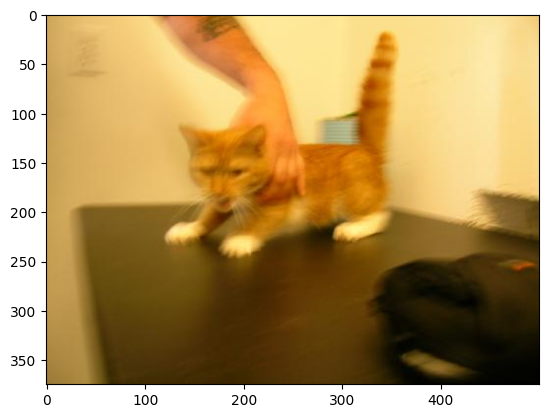

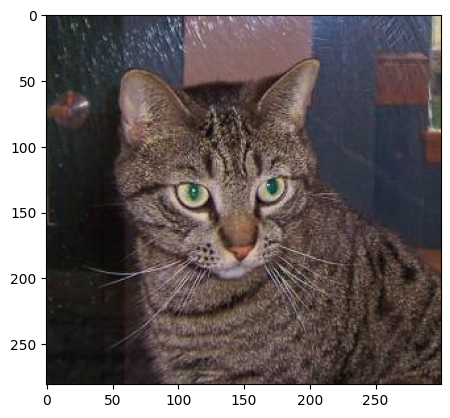

In [5]:
CAT_IMAGE_DIR = os.path.join(BASE_IMAGE_DIR, 'Cat')
DOG_IMAGE_DIR = os.path.join(BASE_IMAGE_DIR, 'Dog')
CORRUPTED_IMAGE_DIR = os.path.join(BASE_IMAGE_DIR, 'corrupted')
TRAINED_MODELS_DIR = os.path.join(BASE_IMAGE_DIR, 'models')
SAVE_DIR = r"C:\dev\programming_2023\cnn_project\training_plots"

if not os.path.exists(CORRUPTED_IMAGE_DIR):
    print("Creating {}".format(CORRUPTED_IMAGE_DIR))
    os.mkdirs(CORRUPTED_IMAGE_DIR)
    
if not os.path.exists(TRAINED_MODELS_DIR):
    print("Creating {}".format(TRAINED_MODELS_DIR))
    os.mkdirs(TRAINED_MODELS_DIR)

    
print("Found {} images in the cat directory.".format(len(os.listdir(CAT_IMAGE_DIR))))
print("Found {} images in the dog directory.".format(len(os.listdir(DOG_IMAGE_DIR))))

# display the first 2 images of the cat directory as a santity check
first_images = os.listdir(CAT_IMAGE_DIR)[:2]
for image in first_images:
    test_img_path = "{}/{}".format(CAT_IMAGE_DIR, image)
    test_img =  cv2.cvtColor(cv2.imread(test_img_path), cv2.COLOR_BGR2RGB)
    
    plt.imshow(test_img)
    plt.show()

## Remove corrupted images

In [6]:
cat_images = os.listdir(CAT_IMAGE_DIR)
for image in cat_images:
    test_img_path = "{}/{}".format(CAT_IMAGE_DIR, image)
    try:
        im = Image.open(test_img_path)
    except:
        print("Found corrupted image: {}. Moving to: {} ".format(test_img_path, CORRUPTED_IMAGE_DIR))
        corrupted_path = "{}/{}".format(CORRUPTED_IMAGE_DIR, image)
        os.rename(test_img_path, corrupted_path)
        continue

dog_images = os.listdir(DOG_IMAGE_DIR)
for image in dog_images:
    test_img_path = "{}/{}".format(DOG_IMAGE_DIR, image)
    try:
        im = Image.open(test_img_path)
    except:
        print("Found corrupted image: {}. Moving to: {} ".format(test_img_path, CORRUPTED_IMAGE_DIR))
        corrupted_path = "{}/{}".format(CORRUPTED_IMAGE_DIR, image)
        os.rename(test_img_path, corrupted_path)
        continue

C:\Users\nates\anaconda3\envs\tflow\lib\site-packages\PIL\TiffImagePlugin.py:864: UserWarning: Truncated File Read
  warnings.warn(str(msg))


## Parameterized class for image classifier to train and test various hyperparameters

In [7]:
class CatDogImageClassifier():
    def __init__(
        self,
        model_name,
        batch_size,
        activation_function, # currently used in the architecture params
        loss_function,
        epochs,
        layer_configs,
        dropout_rate=None
    ):
        self.model_name=model_name
        self.batch_size=batch_size
        self.activation_function=activation_function
        self.loss_function=loss_function
        self.epochs=epochs
        self.layer_configs=layer_configs
        self.dropout_rate=dropout_rate
        
        self.model=None
        self.acc=None
        self.validation_acc=None
        self.loss=None
        self.validation_loss=None
        self.results=None
        self.train_time=None
        
    def build(self):
        
        print("Building model: {}...".format(self.model_name))
        self.model=keras.models.Sequential()
        
        # build the model dynamically based on the layer configs
        for index, layer_config in enumerate(self.layer_configs):
            
            layer_type = layer_config["type"]

            if layer_type == "Conv2D":
                
                # if this is the first layer, we need to specifc the input shape
                if index == 0:
                    conv2d_layer = keras.layers.Conv2D(
                        layer_config["filters"],
                        layer_config["kernel_size"],
                        activation=self.activation_function,
                        padding="same",
                        input_shape=(256, 256,3)
                    )
                else:
                    conv2d_layer = keras.layers.Conv2D(
                        layer_config["filters"],
                        layer_config["kernel_size"],
                        activation=self.activation_function,
                        padding="same",
                    )  
                    
                self.model.add(conv2d_layer)
                    
            elif layer_type == "MaxPooling2D":
                self.model.add(
                    keras.layers.MaxPooling2D(
                        layer_config["pool_size"]
                    )
                )

            elif layer_type == "Dropout":
                
                # class-level dropout rate takes precedence
                if self.dropout_rate is None:
                    self.model.add(keras.layers.Dropout(
                        layer_config["rate"]
                        )
                    )
                else:
                    print("Using dropout rate: {}".format(self.dropout_rate))
                    self.model.add(keras.layers.Dropout(
                        self.dropout_rate
                        )
                    )

            elif layer_type == "Flatten":
                self.model.add(keras.layers.Flatten())

            elif layer_type == "Dense":
                self.model.add(keras.layers.Dense(
                    units=layer_config["units"],
                    activation=layer_config["activation"]
                ))
                
                              
        self.model.summary()
        
        print("Compiling model...")
        
        self.model.compile(
            loss=self.loss_function,
            optimizer=keras.optimizers.Adamax(learning_rate=0.001),
            metrics=['acc']
        )
        
    def train(self, image_dir):

        start = time.time()
        
        if self.model is None:
            raise Exception("Model is not yet build. Call the build() before calling train()")
        
        # expect the labels in 2 image directories
        subdirs = os.listdir(image_dir)
        
        if not 'Cat' in subdirs or not 'Dog' in subdirs:
            raise Exception("Could not find Cat and/or Dog image directory in {}".format(image_dir))
            
        # warn if we don't find a GPU to train on
        if len(tf.config.list_physical_devices('GPU')) < 1:
            print("No GPU found, training on CPU")
            print("WARNING: Training on CPU not advised.")
        
        
        base_generator = ImageDataGenerator(
            rescale=1/255,
            validation_split=.2
        )
        
        # TODO explore chaging these
        height, width=(256, 256)
        
        train_dataset = base_generator.flow_from_directory(
            image_dir,
            target_size=(height, width),
            classes=('Cat', 'Dog'),
            batch_size=self.batch_size,
            subset='training',
        )

        validation_dataset = base_generator.flow_from_directory(
            image_dir,
            target_size=(height, width),
            classes=('Cat', 'Dog'),
            batch_size=self.batch_size,
            subset='validation',
        )
        
        
        # if our validation loss isn't improving, stop training
        early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
        
        self.results = self.model.fit(
            train_dataset,
            validation_data=validation_dataset,
            workers=20,
            epochs=self.epochs
        )
        
        self.train_time = time.time() - start
        
        # set training metrics
        self.accuracy = self.results.history['acc']
        self.validation_acc = self.results.history['val_acc']
        self.loss = self.results.history['loss']
        self.validation_loss = self.results.history['val_loss']
        
        save_dir = "{}/{}/{}".format(image_dir, "models", self.model_name)
        print("Trained model. Attempting to save to: {}".format(save_dir))
        
        if not os.path.exists(save_dir):
            os.mkdirs(save_dir)
            
        self.model.save(save_dir)
        
    def plot_results(self, save_dir=None):
        
        if self.results is None:
            raise Exception("No training results.")
        
        
        epochs = self.results.epoch
        
        fig, ax = plt.subplots(1, 2, figsize=(20,6))

        # plot accuracy
        ax[0].set_title("{}: Accuracy".format(self.model_name))
        ax[0].plot(epochs, self.accuracy, label='Training accuracy')
        ax[0].plot(epochs, self.validation_acc, label='Validation accuracy')
        ax[0].set_xlabel("Epoch")
        ax[0].set_xticks(epochs)
        ax[0].set_ylabel("Accuracy")
        ax[0].legend()

        # plot loss
        ax[1].set_title("{}: Loss".format(self.model_name))
        ax[1].plot(epochs, self.loss, label='Training loss')
        ax[1].plot(epochs, self.validation_loss, label='Validation loss')
        ax[1].set_xlabel("Epoch")
        ax[1].set_xticks(epochs)
        ax[1].set_ylabel("Loss")
        ax[1].legend()
        
        if save_dir is not None:
            path = "{}/{}.png".format(save_dir, self.model_name)
            plt.savefig(path)

        plt.show()

        
        

## Define the paramters based on systematic parameter sweep 

In [9]:
best_config = [
    {'type': 'Conv2D', 'filters': 16, 'kernel_size': (3, 3)}, 
    {'type': 'MaxPooling2D', 'pool_size': (2, 2)}, 
    {'type': 'Dropout', 'rate': 0.30703886128813807}, 
    {'type': 'Flatten'}, 
    {'type': 'Dense', 'units': 256, 'activation': 'tanh'},
    {'type': 'Dense', 'units': 2, 'activation': 'softmax'}
]

best_activation_function = "relu"
best_batch_size = 30
best_loss_function = "binary_crossentropy"
best_dropout_rate = 0.9
epochs_to_train = 30

best_network = CatDogImageClassifier(
    model_name="best_classifier",
    batch_size=best_batch_size,
    activation_function=best_activation_function,
    loss_function=best_loss_function,
    layer_configs=best_config,
    dropout_rate=best_dropout_rate,
    epochs=epochs_to_train
    
)

In [10]:
best_network.build()
best_network.train(BASE_IMAGE_DIR)

Building model: best_classifier...
Using dropout rate: 0.9
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 16)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 128, 128, 16)      0         
                                                                 
 flatten (Flatten)           (None, 262144)            0         
                                                                 
 dense (Dense)               (None, 256)               67109120  
                                                                 
 dense_1 (Dense)             (None, 2)                 514     

KeyboardInterrupt: 

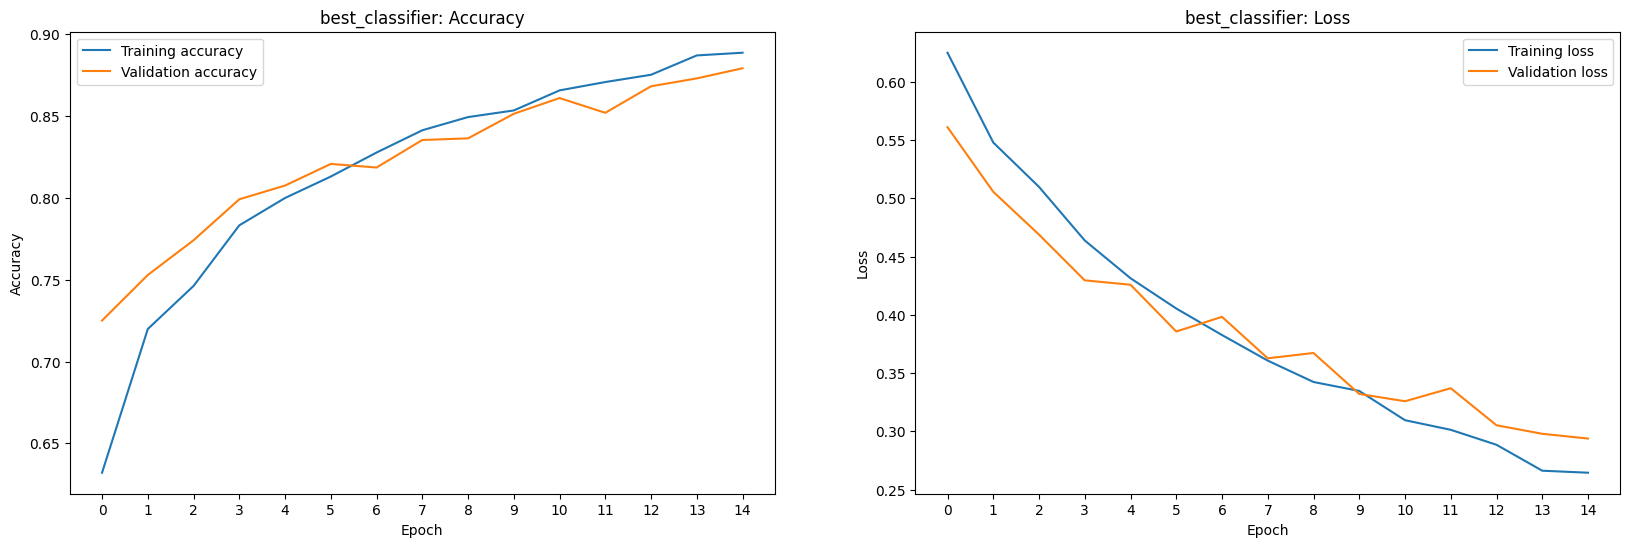

In [10]:
best_network.plot_results(save_dir=SAVE_DIR)

### Hyperparameter tuning - sweep architecture and optimization models

In [8]:
# randomly generate a network configuration
def generate_random_layer_config(layer_type):
    if layer_type == "Conv2D":
        return {
            "type": layer_type,
            "filters": random.choice([16, 32, 64, 128]),
            "kernel_size": random.choice([(3, 3), (5, 5)])
        }

    elif layer_type == "MaxPooling2D":
        return {
            "type": layer_type,
            "pool_size": random.choice([(2, 2), (3, 3)])
        }

    elif layer_type == "Dropout":
        return {
            "type": layer_type,
            "rate": random.uniform(0.5, 0.9)
        }

    elif layer_type == "Flatten":
        return {
            "type": layer_type
        }

    elif layer_type == "Dense":
        return {
            "type": layer_type,
            "units": random.choice([64, 128, 256, 512]),
            "activation": random.choice(["relu", "sigmoid", "tanh"])
        }


def generate_constrained_layer_config_list():
    layer_list = []

    # randomly choose the number of convolutional blocks
    num_conv_blocks = random.randint(1, 4)

    # ensure any conv layer is followed by max pooling layers
    for _ in range(num_conv_blocks):
        layer_list.append(generate_random_layer_config("Conv2D"))
        layer_list.append(generate_random_layer_config("MaxPooling2D"))

        # optionally add dropout layers after MaxPooling2D layers
        if random.random() < 0.5:
            layer_list.append(generate_random_layer_config("Dropout"))

    # add a Flatten layer before the first Dense layer
    layer_list.append(generate_random_layer_config("Flatten"))

    # randomly choose the number of dense layers (excluding the last one)
    num_dense_layers = random.randint(0, 2)

    for _ in range(num_dense_layers):
        layer_list.append(generate_random_layer_config("Dense"))

    # The last layer is Dense with softmax activation
    layer_list.append({
        "type": "Dense",
        "units": 2,
        "activation": "softmax"
    })

    return layer_list

In [9]:
# define an function to sweep architecutre params
def sweep_architecture_params(image_dir, n_trials, other_params):
    best_validation_acc = 0
    best_config = None

    for trial in range(n_trials):
        config = generate_constrained_layer_config_list()
        print("Testing architecture config (trial {}): {}".format(trial + 1, config))

        model = CatDogImageClassifier(
            model_name="architecture_sweep",
            batch_size=other_params["batch_size"],
            activation_function=other_params["activation_function"],
            loss_function=other_params["loss_function"],
            epochs=other_params["epochs"],
            layer_configs=config
        )

        try:
            model.build()
            model.train(image_dir)
            model.plot_results()
        except Exception as e:
            print("Failed to train: {}".format(e))
            continue

        # grab the highest-achieved validation accuracy
        current_validation_acc = max(model.validation_acc)

        if current_validation_acc > best_validation_acc:
            best_validation_acc = current_validation_acc
            best_config = config

        print("Current best validation accuracy: ", best_validation_acc)

    print("Best config: {}".format(best_config))
    return best_config


# define a function to sweep non-config params - (run after we decided on overall architecture)
def grid_search(image_dir, layer_configs, activation_functions, batch_sizes, loss_functions, epochs_list, dropout_rates):

    # Generate all combinations of parameters
    param_combinations = list(itertools.product(activation_functions, batch_sizes, loss_functions, epochs_list, dropout_rates))

    results = []

    for activation_function, batch_size, loss_function, epoch, dropout_rate in param_combinations:
        model_name = f"model_{activation_function}_{batch_size}_{loss_function}_{epoch}_{dropout_rate}"
        print(f"Training model: {model_name}")

        # create and build the model with the current parameter combination
        classifier = CatDogImageClassifier(
            model_name=model_name,
            batch_size=batch_size,
            activation_function=activation_function,
            loss_function=loss_function,
            epochs=epoch,
            layer_configs=layer_configs,
            dropout_rate=dropout_rate
        )

        try:
            classifier.build()
            classifier.train(image_dir)
        except Exception as e:
            print("Failed to train network: {}. {}".format(model_name, e))

        # Append the results to the results list
        results.append({
            'model_name': model_name,
            'activation_function': activation_function,
            'batch_size': batch_size,
            'loss_function': loss_function,
            'epochs': epoch,
            'accuracy': classifier.accuracy,
            'validation_accuracy': classifier.validation_acc,
            'loss': classifier.loss,
            'validation_loss': classifier.validation_loss
        })
        
    return results



Testing architecture config (trial 1): [{'type': 'Conv2D', 'filters': 64, 'kernel_size': (5, 5)}, {'type': 'MaxPooling2D', 'pool_size': (2, 2)}, {'type': 'Dropout', 'rate': 0.5073130664109685}, {'type': 'Conv2D', 'filters': 16, 'kernel_size': (3, 3)}, {'type': 'MaxPooling2D', 'pool_size': (2, 2)}, {'type': 'Flatten'}, {'type': 'Dense', 'units': 2, 'activation': 'softmax'}]
Building model: architecture_sweep...
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 64)      4864      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 64)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 128, 128, 64)      0         
                                      

INFO:tensorflow:Assets written to: C:\dev\programming_2023\cnn_project\kagglecatsanddogs_5340\PetImages/models/architecture_sweep\assets


INFO:tensorflow:Assets written to: C:\dev\programming_2023\cnn_project\kagglecatsanddogs_5340\PetImages/models/architecture_sweep\assets


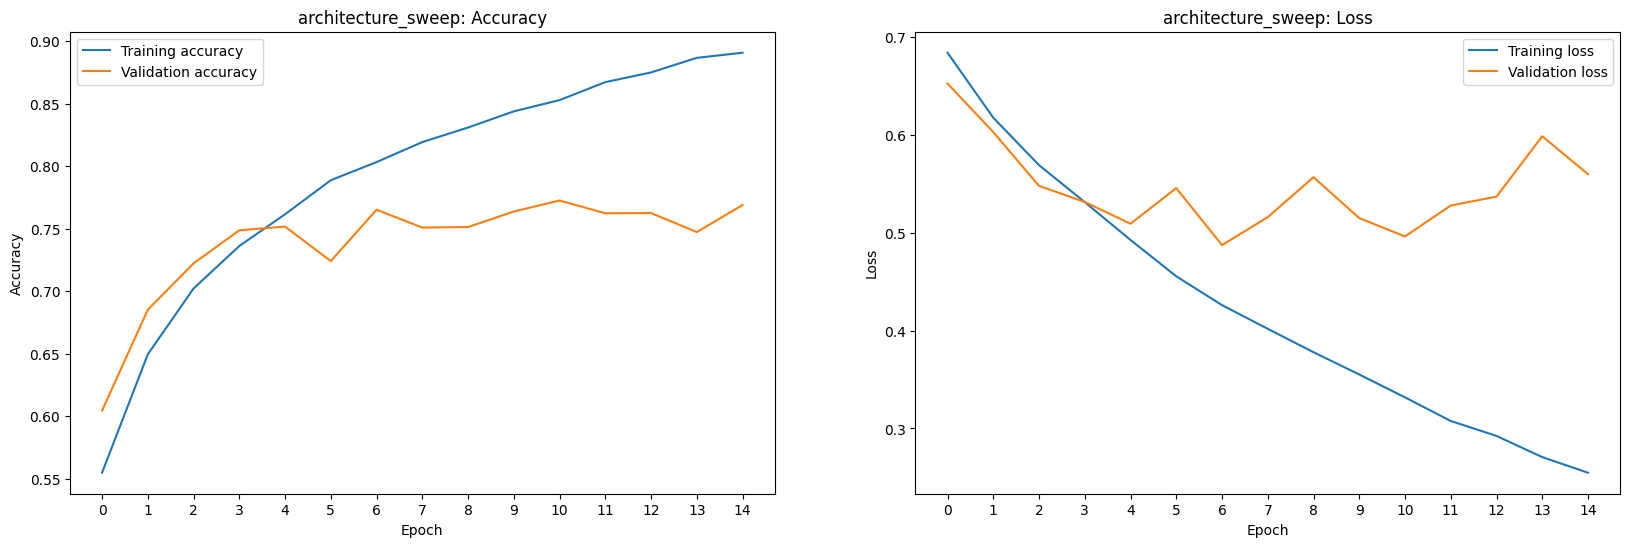

Current best validation accuracy:  0.7725270390510559
Testing architecture config (trial 2): [{'type': 'Conv2D', 'filters': 16, 'kernel_size': (5, 5)}, {'type': 'MaxPooling2D', 'pool_size': (3, 3)}, {'type': 'Flatten'}, {'type': 'Dense', 'units': 2, 'activation': 'softmax'}]
Building model: architecture_sweep...
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 256, 256, 16)      1216      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 85, 85, 16)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 115600)            0         
                                                                 
 dense_1 (Dense)             (None, 2)                 231202    
    

C:\Users\nates\anaconda3\envs\tflow\lib\site-packages\PIL\TiffImagePlugin.py:864: UserWarning: Truncated File Read
  warnings.warn(str(msg))


625/625 [==============================] - 23s 35ms/step - loss: 0.6388 - acc: 0.6430 - val_loss: 0.5839 - val_acc: 0.6780
Epoch 2/15
625/625 [==============================] - 22s 35ms/step - loss: 0.5353 - acc: 0.7347 - val_loss: 0.5342 - val_acc: 0.7329
Epoch 3/15
625/625 [==============================] - 24s 39ms/step - loss: 0.4898 - acc: 0.7665 - val_loss: 0.5230 - val_acc: 0.7375
Epoch 4/15
625/625 [==============================] - 26s 42ms/step - loss: 0.4527 - acc: 0.7917 - val_loss: 0.5194 - val_acc: 0.7409
Epoch 5/15
625/625 [==============================] - 24s 39ms/step - loss: 0.4169 - acc: 0.8139 - val_loss: 0.5282 - val_acc: 0.7409
Epoch 6/15
625/625 [==============================] - 22s 35ms/step - loss: 0.3802 - acc: 0.8369 - val_loss: 0.5223 - val_acc: 0.7505
Epoch 7/15
625/625 [==============================] - 23s 36ms/step - loss: 0.3498 - acc: 0.8527 - val_loss: 0.5330 - val_acc: 0.7427
Epoch 8/15
625/625 [==============================] - 24s 38ms/step - los

INFO:tensorflow:Assets written to: C:\dev\programming_2023\cnn_project\kagglecatsanddogs_5340\PetImages/models/architecture_sweep\assets


INFO:tensorflow:Assets written to: C:\dev\programming_2023\cnn_project\kagglecatsanddogs_5340\PetImages/models/architecture_sweep\assets


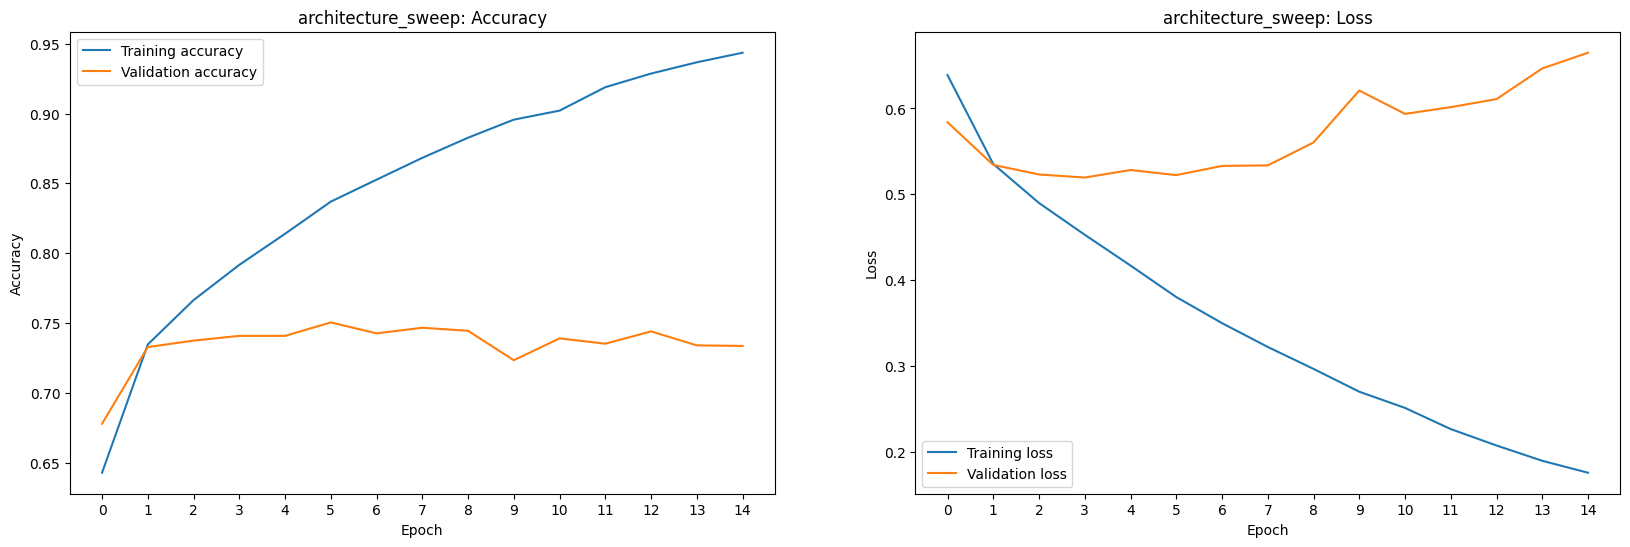

Current best validation accuracy:  0.7725270390510559
Testing architecture config (trial 3): [{'type': 'Conv2D', 'filters': 16, 'kernel_size': (5, 5)}, {'type': 'MaxPooling2D', 'pool_size': (3, 3)}, {'type': 'Dropout', 'rate': 0.1620943893386202}, {'type': 'Conv2D', 'filters': 64, 'kernel_size': (5, 5)}, {'type': 'MaxPooling2D', 'pool_size': (3, 3)}, {'type': 'Flatten'}, {'type': 'Dense', 'units': 256, 'activation': 'sigmoid'}, {'type': 'Dense', 'units': 512, 'activation': 'relu'}, {'type': 'Dense', 'units': 2, 'activation': 'softmax'}]
Building model: architecture_sweep...
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 256, 256, 16)      1216      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 85, 85, 16)       0         
 2D)                                                             
 

C:\Users\nates\anaconda3\envs\tflow\lib\site-packages\PIL\TiffImagePlugin.py:864: UserWarning: Truncated File Read
  warnings.warn(str(msg))


625/625 [==============================] - 35s 54ms/step - loss: 0.5793 - acc: 0.6858 - val_loss: 0.5003 - val_acc: 0.7467
Epoch 2/15
625/625 [==============================] - 32s 51ms/step - loss: 0.4646 - acc: 0.7797 - val_loss: 0.5294 - val_acc: 0.7465
Epoch 3/15
625/625 [==============================] - 33s 52ms/step - loss: 0.4078 - acc: 0.8126 - val_loss: 0.4578 - val_acc: 0.7835
Epoch 4/15
625/625 [==============================] - 33s 52ms/step - loss: 0.3578 - acc: 0.8411 - val_loss: 0.4471 - val_acc: 0.7875
Epoch 5/15
625/625 [==============================] - 33s 52ms/step - loss: 0.3027 - acc: 0.8711 - val_loss: 0.4267 - val_acc: 0.8130
Epoch 6/15
625/625 [==============================] - 35s 55ms/step - loss: 0.2461 - acc: 0.8994 - val_loss: 0.5227 - val_acc: 0.7871
Epoch 7/15
625/625 [==============================] - 37s 58ms/step - loss: 0.1940 - acc: 0.9206 - val_loss: 0.5272 - val_acc: 0.7972
Epoch 8/15
625/625 [==============================] - 31s 49ms/step - los

INFO:tensorflow:Assets written to: C:\dev\programming_2023\cnn_project\kagglecatsanddogs_5340\PetImages/models/architecture_sweep\assets


INFO:tensorflow:Assets written to: C:\dev\programming_2023\cnn_project\kagglecatsanddogs_5340\PetImages/models/architecture_sweep\assets


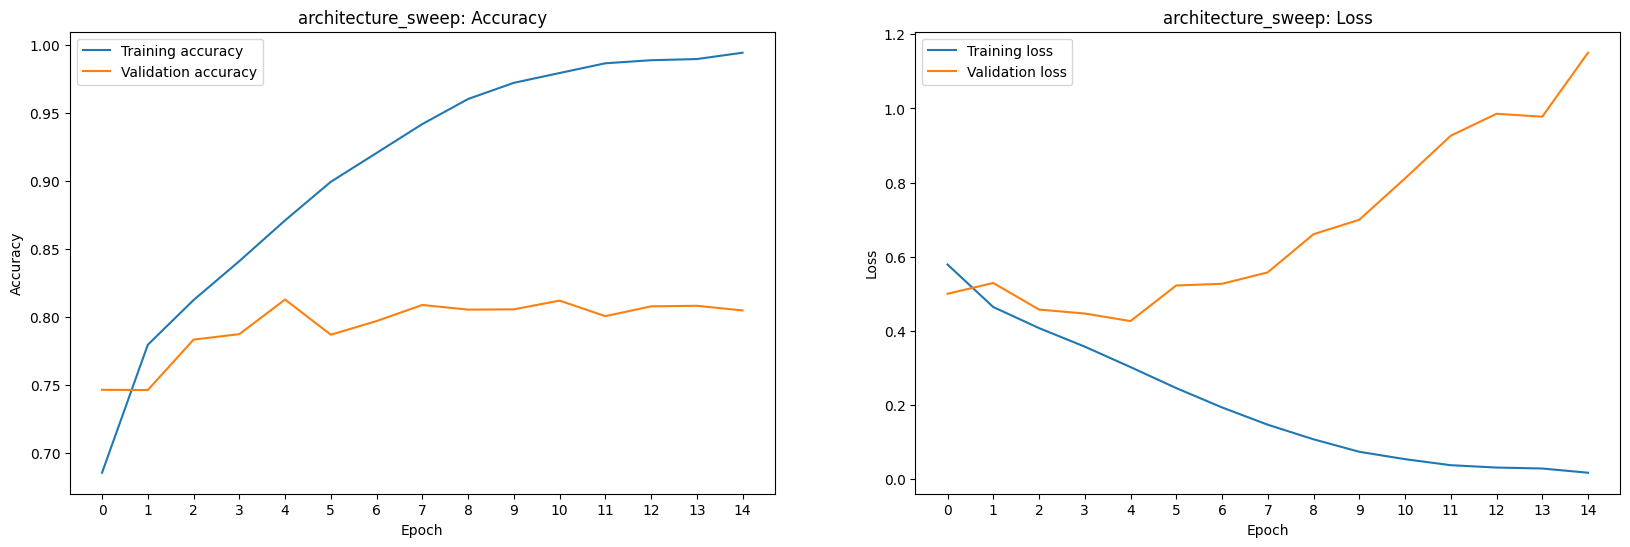

Current best validation accuracy:  0.8129755854606628
Testing architecture config (trial 4): [{'type': 'Conv2D', 'filters': 16, 'kernel_size': (3, 3)}, {'type': 'MaxPooling2D', 'pool_size': (2, 2)}, {'type': 'Conv2D', 'filters': 64, 'kernel_size': (5, 5)}, {'type': 'MaxPooling2D', 'pool_size': (2, 2)}, {'type': 'Conv2D', 'filters': 32, 'kernel_size': (3, 3)}, {'type': 'MaxPooling2D', 'pool_size': (2, 2)}, {'type': 'Flatten'}, {'type': 'Dense', 'units': 512, 'activation': 'relu'}, {'type': 'Dense', 'units': 128, 'activation': 'tanh'}, {'type': 'Dense', 'units': 2, 'activation': 'softmax'}]
Building model: architecture_sweep...
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 256, 256, 16)      448       
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 128, 128, 16)     0         
 2D)          

C:\Users\nates\anaconda3\envs\tflow\lib\site-packages\PIL\TiffImagePlugin.py:864: UserWarning: Truncated File Read
  warnings.warn(str(msg))


625/625 [==============================] - 43s 67ms/step - loss: 0.6234 - acc: 0.6334 - val_loss: 0.5228 - val_acc: 0.7389
Epoch 2/15
625/625 [==============================] - 39s 62ms/step - loss: 0.4955 - acc: 0.7568 - val_loss: 0.5412 - val_acc: 0.7213
Epoch 3/15
625/625 [==============================] - 42s 67ms/step - loss: 0.4153 - acc: 0.8060 - val_loss: 0.4466 - val_acc: 0.7944
Epoch 4/15
625/625 [==============================] - 44s 70ms/step - loss: 0.3371 - acc: 0.8514 - val_loss: 0.4357 - val_acc: 0.8012
Epoch 5/15
625/625 [==============================] - 49s 79ms/step - loss: 0.2327 - acc: 0.9047 - val_loss: 0.5114 - val_acc: 0.8024
Epoch 6/15
625/625 [==============================] - 44s 70ms/step - loss: 0.1217 - acc: 0.9543 - val_loss: 0.6082 - val_acc: 0.8060
Epoch 7/15
625/625 [==============================] - 38s 61ms/step - loss: 0.0455 - acc: 0.9852 - val_loss: 0.9074 - val_acc: 0.7950
Epoch 8/15
625/625 [==============================] - 41s 66ms/step - los

INFO:tensorflow:Assets written to: C:\dev\programming_2023\cnn_project\kagglecatsanddogs_5340\PetImages/models/architecture_sweep\assets


INFO:tensorflow:Assets written to: C:\dev\programming_2023\cnn_project\kagglecatsanddogs_5340\PetImages/models/architecture_sweep\assets


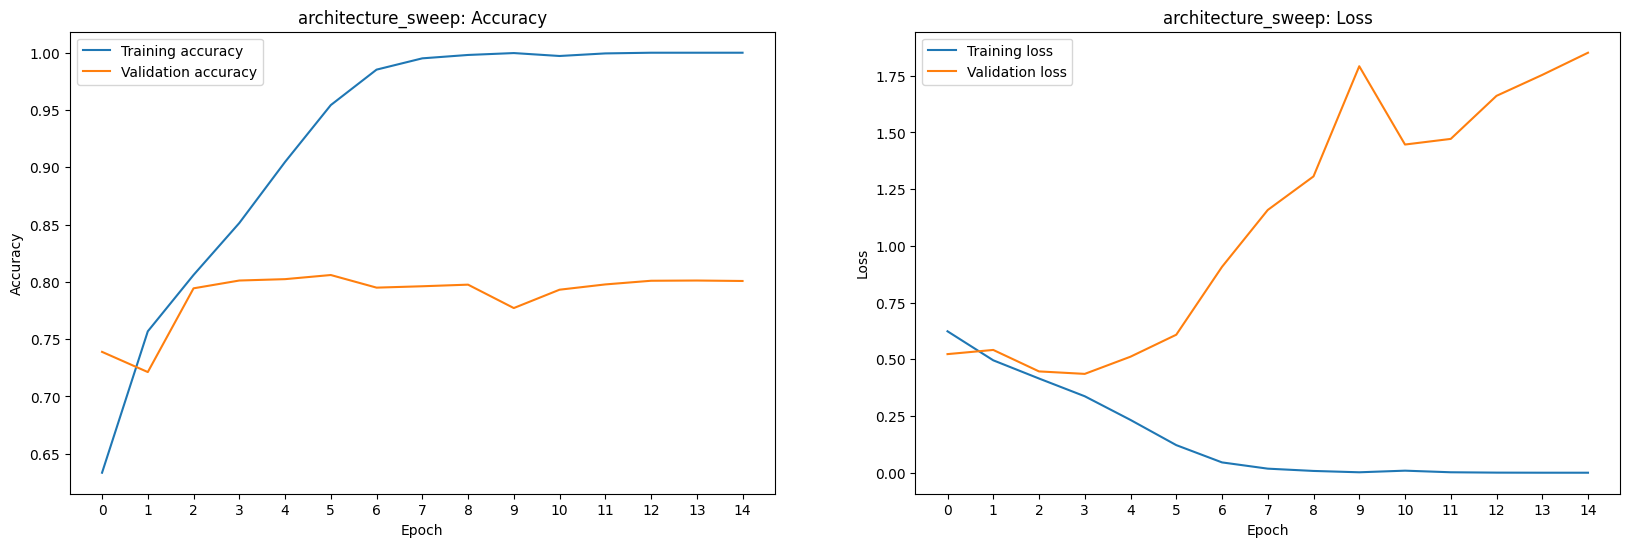

Current best validation accuracy:  0.8129755854606628
Testing architecture config (trial 5): [{'type': 'Conv2D', 'filters': 128, 'kernel_size': (5, 5)}, {'type': 'MaxPooling2D', 'pool_size': (3, 3)}, {'type': 'Dropout', 'rate': 0.15641402293341253}, {'type': 'Conv2D', 'filters': 64, 'kernel_size': (3, 3)}, {'type': 'MaxPooling2D', 'pool_size': (3, 3)}, {'type': 'Dropout', 'rate': 0.4809624965195345}, {'type': 'Conv2D', 'filters': 16, 'kernel_size': (3, 3)}, {'type': 'MaxPooling2D', 'pool_size': (2, 2)}, {'type': 'Dropout', 'rate': 0.34735936234780607}, {'type': 'Flatten'}, {'type': 'Dense', 'units': 2, 'activation': 'softmax'}]
Building model: architecture_sweep...
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 256, 256, 128)     9728      
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 85,

C:\Users\nates\anaconda3\envs\tflow\lib\site-packages\PIL\TiffImagePlugin.py:864: UserWarning: Truncated File Read
  warnings.warn(str(msg))


625/625 [==============================] - 62s 97ms/step - loss: 0.6734 - acc: 0.5630 - val_loss: 0.6369 - val_acc: 0.6372
Epoch 2/15
625/625 [==============================] - 61s 96ms/step - loss: 0.6002 - acc: 0.6726 - val_loss: 0.5534 - val_acc: 0.7297
Epoch 3/15
625/625 [==============================] - 62s 99ms/step - loss: 0.5306 - acc: 0.7371 - val_loss: 0.4984 - val_acc: 0.7587
Epoch 4/15
625/625 [==============================] - 62s 98ms/step - loss: 0.5016 - acc: 0.7565 - val_loss: 0.4825 - val_acc: 0.7657
Epoch 5/15
625/625 [==============================] - 61s 97ms/step - loss: 0.4719 - acc: 0.7762 - val_loss: 0.4519 - val_acc: 0.7974
Epoch 6/15
625/625 [==============================] - 63s 101ms/step - loss: 0.4500 - acc: 0.7898 - val_loss: 0.4437 - val_acc: 0.8010
Epoch 7/15
625/625 [==============================] - 64s 101ms/step - loss: 0.4345 - acc: 0.7998 - val_loss: 0.4250 - val_acc: 0.8154
Epoch 8/15
625/625 [==============================] - 64s 102ms/step - 

INFO:tensorflow:Assets written to: C:\dev\programming_2023\cnn_project\kagglecatsanddogs_5340\PetImages/models/architecture_sweep\assets


INFO:tensorflow:Assets written to: C:\dev\programming_2023\cnn_project\kagglecatsanddogs_5340\PetImages/models/architecture_sweep\assets


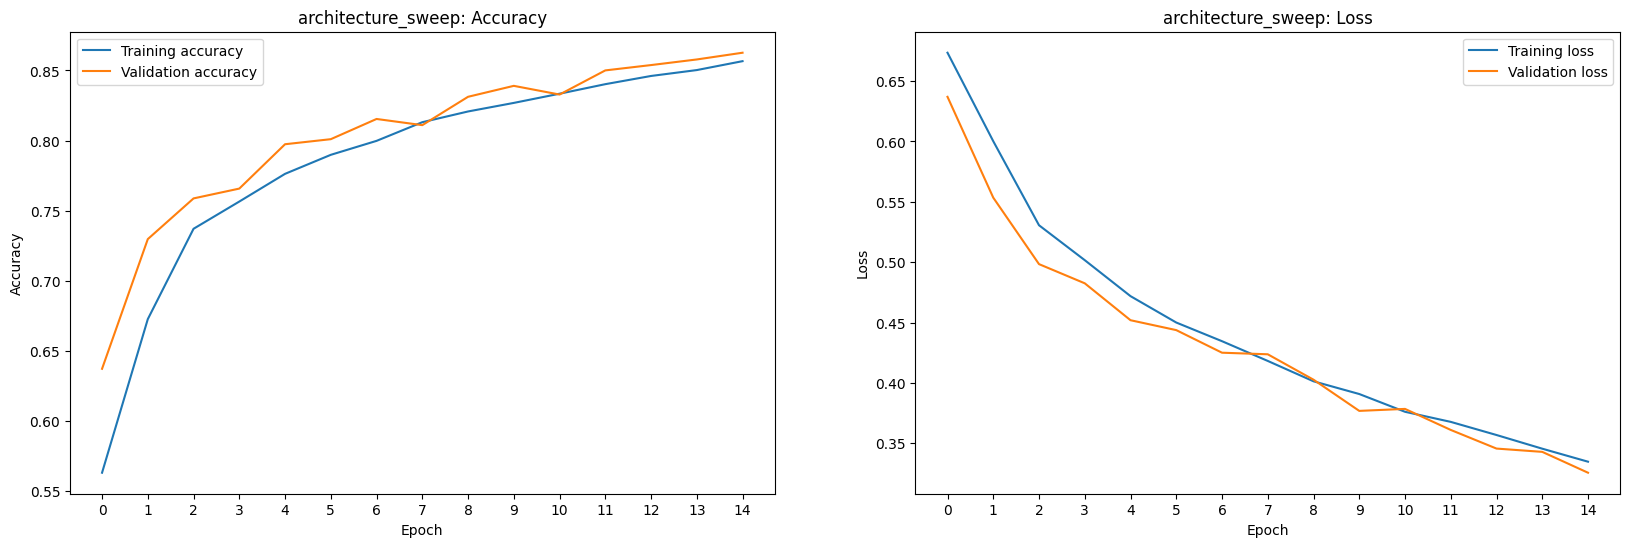

Current best validation accuracy:  0.8626351356506348
Testing architecture config (trial 6): [{'type': 'Conv2D', 'filters': 16, 'kernel_size': (3, 3)}, {'type': 'MaxPooling2D', 'pool_size': (2, 2)}, {'type': 'Dropout', 'rate': 0.6027598423713575}, {'type': 'Flatten'}, {'type': 'Dense', 'units': 2, 'activation': 'softmax'}]
Building model: architecture_sweep...
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_11 (Conv2D)          (None, 256, 256, 16)      448       
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 128, 128, 16)     0         
 g2D)                                                            
                                                                 
 dropout_5 (Dropout)         (None, 128, 128, 16)      0         
                                                                 
 flatten_5 (Flatten) 

C:\Users\nates\anaconda3\envs\tflow\lib\site-packages\PIL\TiffImagePlugin.py:864: UserWarning: Truncated File Read
  warnings.warn(str(msg))


625/625 [==============================] - 25s 39ms/step - loss: 0.6971 - acc: 0.6154 - val_loss: 0.5891 - val_acc: 0.6892
Epoch 2/15
625/625 [==============================] - 22s 36ms/step - loss: 0.5725 - acc: 0.6992 - val_loss: 0.5796 - val_acc: 0.7056
Epoch 3/15
625/625 [==============================] - 25s 39ms/step - loss: 0.5275 - acc: 0.7407 - val_loss: 0.5523 - val_acc: 0.7245
Epoch 4/15
625/625 [==============================] - 23s 36ms/step - loss: 0.4890 - acc: 0.7673 - val_loss: 0.5403 - val_acc: 0.7355
Epoch 5/15
625/625 [==============================] - 23s 36ms/step - loss: 0.4515 - acc: 0.7924 - val_loss: 0.5921 - val_acc: 0.6922
Epoch 6/15
625/625 [==============================] - 25s 39ms/step - loss: 0.4233 - acc: 0.8127 - val_loss: 0.5333 - val_acc: 0.7425
Epoch 7/15
625/625 [==============================] - 22s 35ms/step - loss: 0.3964 - acc: 0.8274 - val_loss: 0.5499 - val_acc: 0.7267
Epoch 8/15
625/625 [==============================] - 24s 39ms/step - los

INFO:tensorflow:Assets written to: C:\dev\programming_2023\cnn_project\kagglecatsanddogs_5340\PetImages/models/architecture_sweep\assets


INFO:tensorflow:Assets written to: C:\dev\programming_2023\cnn_project\kagglecatsanddogs_5340\PetImages/models/architecture_sweep\assets


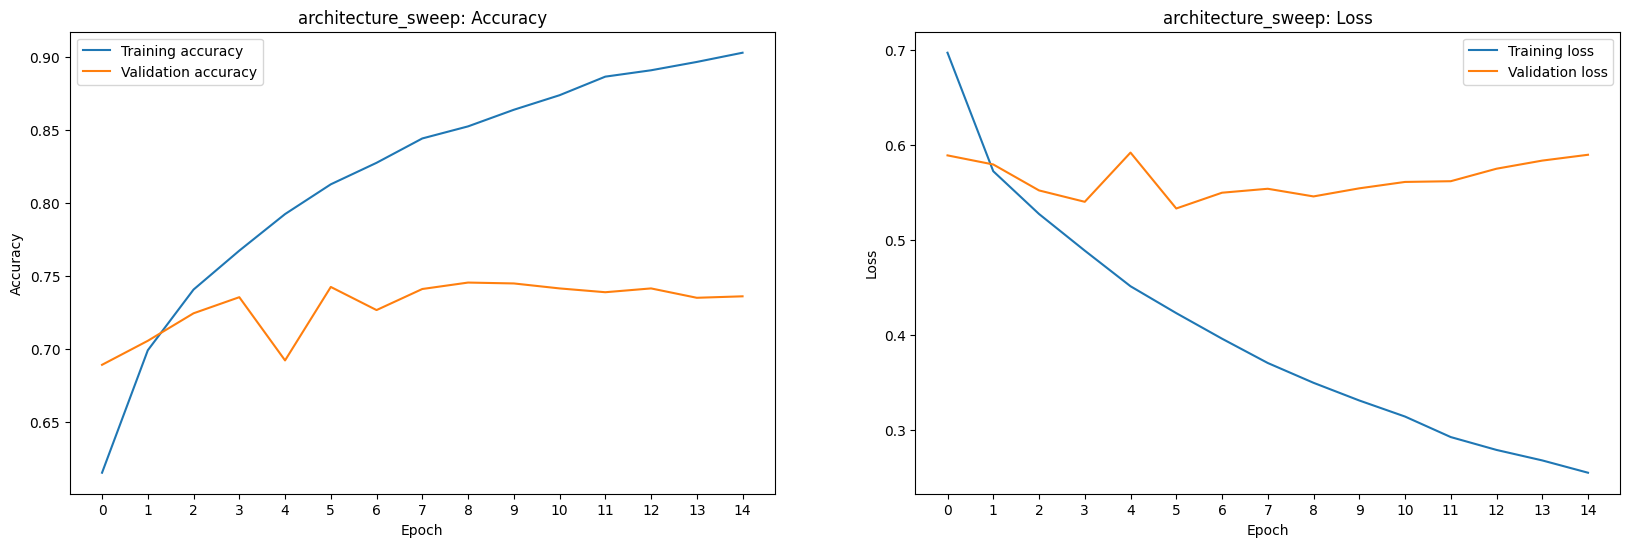

Current best validation accuracy:  0.8626351356506348
Testing architecture config (trial 7): [{'type': 'Conv2D', 'filters': 32, 'kernel_size': (3, 3)}, {'type': 'MaxPooling2D', 'pool_size': (2, 2)}, {'type': 'Conv2D', 'filters': 128, 'kernel_size': (5, 5)}, {'type': 'MaxPooling2D', 'pool_size': (2, 2)}, {'type': 'Dropout', 'rate': 0.21336248443609424}, {'type': 'Conv2D', 'filters': 64, 'kernel_size': (5, 5)}, {'type': 'MaxPooling2D', 'pool_size': (2, 2)}, {'type': 'Dropout', 'rate': 0.5610396422061218}, {'type': 'Flatten'}, {'type': 'Dense', 'units': 64, 'activation': 'tanh'}, {'type': 'Dense', 'units': 512, 'activation': 'relu'}, {'type': 'Dense', 'units': 2, 'activation': 'softmax'}]
Building model: architecture_sweep...
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 256, 256, 32)      896       
                                               

C:\Users\nates\anaconda3\envs\tflow\lib\site-packages\PIL\TiffImagePlugin.py:864: UserWarning: Truncated File Read
  warnings.warn(str(msg))


625/625 [==============================] - 93s 146ms/step - loss: 0.5935 - acc: 0.6632 - val_loss: 0.5111 - val_acc: 0.7451
Epoch 2/15
625/625 [==============================] - 91s 146ms/step - loss: 0.4810 - acc: 0.7646 - val_loss: 0.4516 - val_acc: 0.7789
Epoch 3/15
625/625 [==============================] - 93s 148ms/step - loss: 0.4159 - acc: 0.8071 - val_loss: 0.4007 - val_acc: 0.8208
Epoch 4/15
625/625 [==============================] - 93s 148ms/step - loss: 0.3541 - acc: 0.8430 - val_loss: 0.3799 - val_acc: 0.8336
Epoch 5/15
625/625 [==============================] - 93s 148ms/step - loss: 0.2979 - acc: 0.8727 - val_loss: 0.3956 - val_acc: 0.8244
Epoch 6/15
625/625 [==============================] - 94s 151ms/step - loss: 0.2482 - acc: 0.8955 - val_loss: 0.3415 - val_acc: 0.8538
Epoch 7/15
625/625 [==============================] - 92s 146ms/step - loss: 0.2112 - acc: 0.9122 - val_loss: 0.3616 - val_acc: 0.8536
Epoch 8/15
625/625 [==============================] - 92s 147ms/st

INFO:tensorflow:Assets written to: C:\dev\programming_2023\cnn_project\kagglecatsanddogs_5340\PetImages/models/architecture_sweep\assets


INFO:tensorflow:Assets written to: C:\dev\programming_2023\cnn_project\kagglecatsanddogs_5340\PetImages/models/architecture_sweep\assets


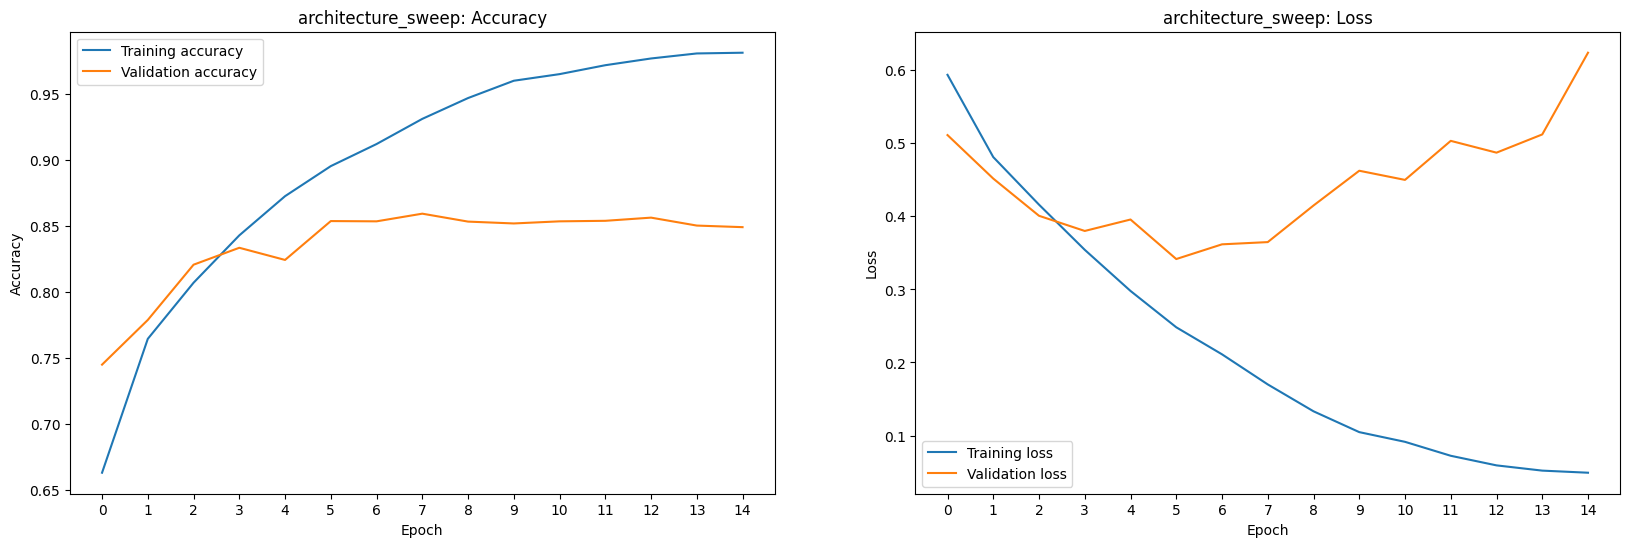

Current best validation accuracy:  0.8626351356506348
Testing architecture config (trial 8): [{'type': 'Conv2D', 'filters': 32, 'kernel_size': (3, 3)}, {'type': 'MaxPooling2D', 'pool_size': (2, 2)}, {'type': 'Dropout', 'rate': 0.2135730242387801}, {'type': 'Conv2D', 'filters': 32, 'kernel_size': (5, 5)}, {'type': 'MaxPooling2D', 'pool_size': (3, 3)}, {'type': 'Dropout', 'rate': 0.15512536926645215}, {'type': 'Flatten'}, {'type': 'Dense', 'units': 256, 'activation': 'sigmoid'}, {'type': 'Dense', 'units': 64, 'activation': 'relu'}, {'type': 'Dense', 'units': 2, 'activation': 'softmax'}]
Building model: architecture_sweep...
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 256, 256, 32)      896       
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 128, 128, 32)     0         
 g2D)             

C:\Users\nates\anaconda3\envs\tflow\lib\site-packages\PIL\TiffImagePlugin.py:864: UserWarning: Truncated File Read
  warnings.warn(str(msg))


625/625 [==============================] - 79s 125ms/step - loss: 0.6407 - acc: 0.6237 - val_loss: 0.6058 - val_acc: 0.6494
Epoch 2/15
625/625 [==============================] - 81s 128ms/step - loss: 0.4970 - acc: 0.7586 - val_loss: 0.4690 - val_acc: 0.7779
Epoch 3/15
625/625 [==============================] - 78s 125ms/step - loss: 0.4300 - acc: 0.7990 - val_loss: 0.4479 - val_acc: 0.7944
Epoch 4/15
625/625 [==============================] - 79s 126ms/step - loss: 0.3707 - acc: 0.8369 - val_loss: 0.4567 - val_acc: 0.7867
Epoch 5/15
625/625 [==============================] - 78s 125ms/step - loss: 0.3189 - acc: 0.8639 - val_loss: 0.4434 - val_acc: 0.8030
Epoch 6/15
625/625 [==============================] - 81s 129ms/step - loss: 0.2689 - acc: 0.8874 - val_loss: 0.4598 - val_acc: 0.8000
Epoch 7/15
625/625 [==============================] - 77s 123ms/step - loss: 0.2132 - acc: 0.9158 - val_loss: 0.4876 - val_acc: 0.8100
Epoch 8/15
625/625 [==============================] - 78s 125ms/st

INFO:tensorflow:Assets written to: C:\dev\programming_2023\cnn_project\kagglecatsanddogs_5340\PetImages/models/architecture_sweep\assets


INFO:tensorflow:Assets written to: C:\dev\programming_2023\cnn_project\kagglecatsanddogs_5340\PetImages/models/architecture_sweep\assets


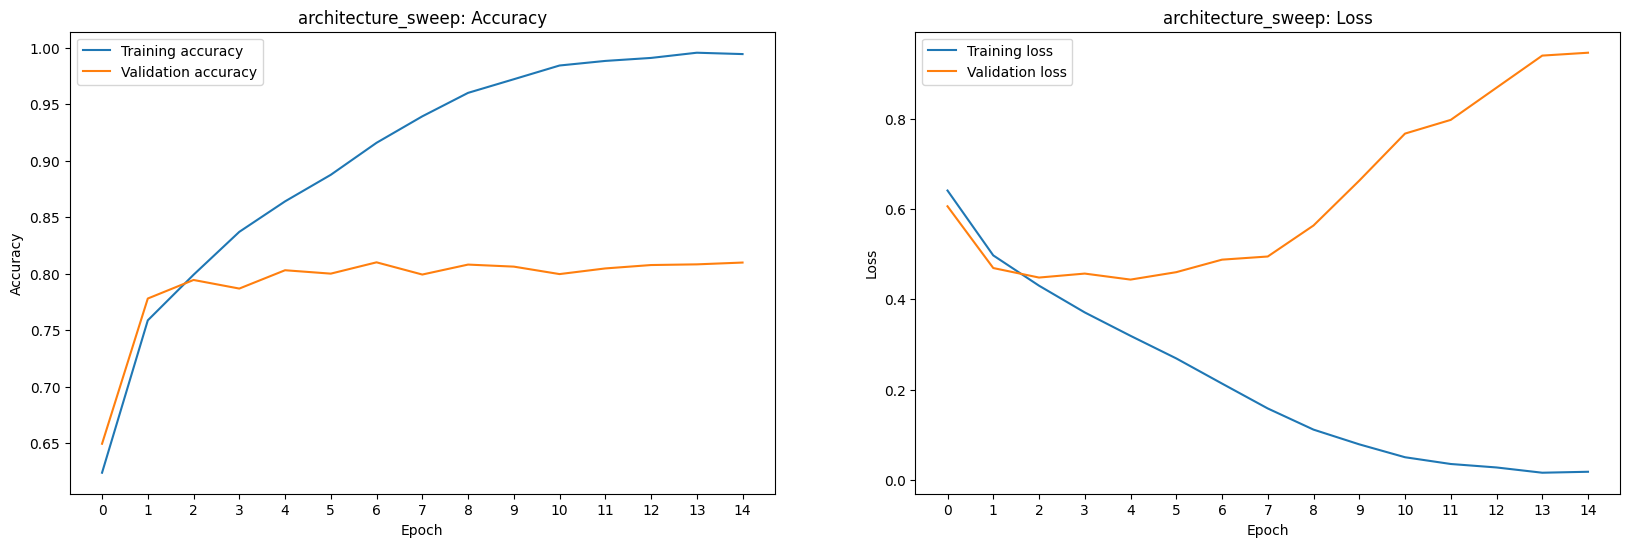

Current best validation accuracy:  0.8626351356506348
Testing architecture config (trial 9): [{'type': 'Conv2D', 'filters': 32, 'kernel_size': (5, 5)}, {'type': 'MaxPooling2D', 'pool_size': (2, 2)}, {'type': 'Dropout', 'rate': 0.49713250972983736}, {'type': 'Flatten'}, {'type': 'Dense', 'units': 512, 'activation': 'relu'}, {'type': 'Dense', 'units': 64, 'activation': 'tanh'}, {'type': 'Dense', 'units': 2, 'activation': 'softmax'}]
Building model: architecture_sweep...
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_17 (Conv2D)          (None, 256, 256, 32)      2432      
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 128, 128, 32)     0         
 g2D)                                                            
                                                                 
 dropout_10 (Dropout)        (None, 128, 12

C:\Users\nates\anaconda3\envs\tflow\lib\site-packages\PIL\TiffImagePlugin.py:864: UserWarning: Truncated File Read
  warnings.warn(str(msg))


625/625 [==============================] - 55s 86ms/step - loss: 0.8559 - acc: 0.4967 - val_loss: 0.6937 - val_acc: 0.5000
Epoch 2/15
625/625 [==============================] - 49s 77ms/step - loss: 0.6937 - acc: 0.5025 - val_loss: 0.6932 - val_acc: 0.5000
Epoch 3/15
625/625 [==============================] - 50s 80ms/step - loss: 0.6936 - acc: 0.4963 - val_loss: 0.6940 - val_acc: 0.5000
Epoch 4/15
625/625 [==============================] - 52s 83ms/step - loss: 0.6936 - acc: 0.5034 - val_loss: 0.6938 - val_acc: 0.5000
Epoch 5/15
625/625 [==============================] - 50s 79ms/step - loss: 0.6936 - acc: 0.4980 - val_loss: 0.6934 - val_acc: 0.5000
Epoch 6/15
625/625 [==============================] - 53s 84ms/step - loss: 0.6939 - acc: 0.5014 - val_loss: 0.6939 - val_acc: 0.5000
Epoch 7/15
625/625 [==============================] - 52s 83ms/step - loss: 0.6936 - acc: 0.5005 - val_loss: 0.6934 - val_acc: 0.5000
Epoch 8/15
625/625 [==============================] - 49s 78ms/step - los

INFO:tensorflow:Assets written to: C:\dev\programming_2023\cnn_project\kagglecatsanddogs_5340\PetImages/models/architecture_sweep\assets


INFO:tensorflow:Assets written to: C:\dev\programming_2023\cnn_project\kagglecatsanddogs_5340\PetImages/models/architecture_sweep\assets


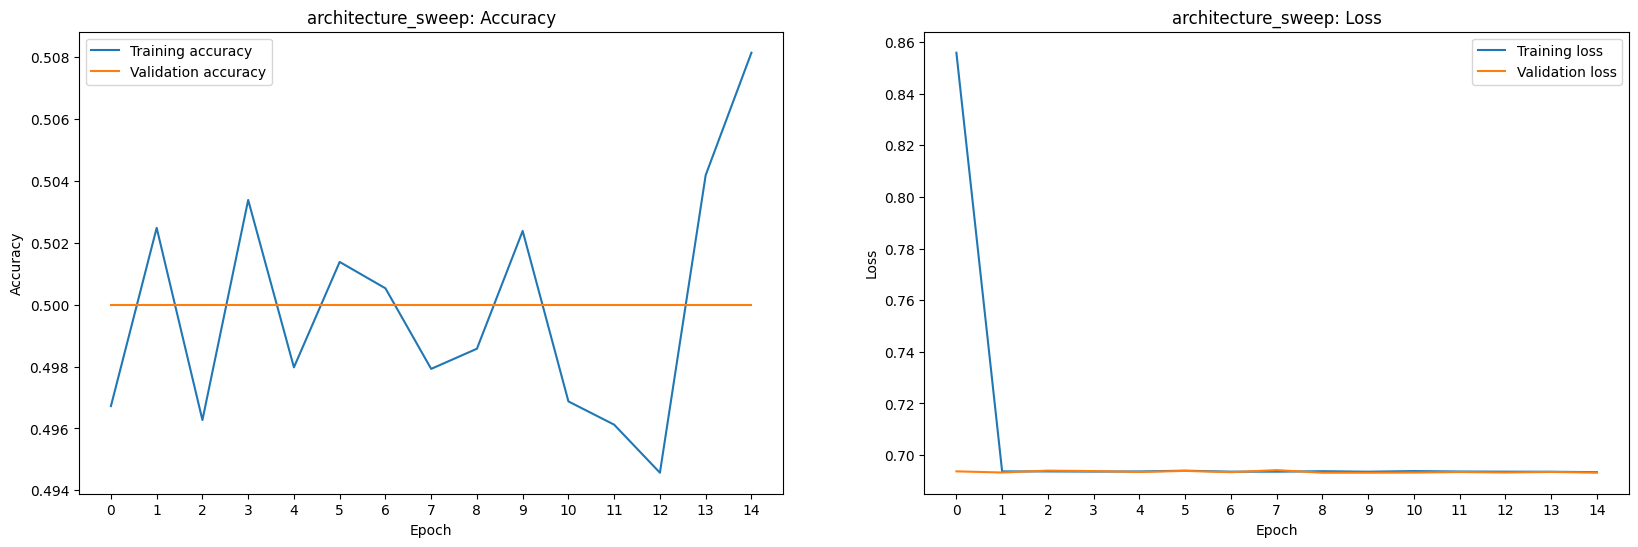

Current best validation accuracy:  0.8626351356506348
Testing architecture config (trial 10): [{'type': 'Conv2D', 'filters': 32, 'kernel_size': (5, 5)}, {'type': 'MaxPooling2D', 'pool_size': (2, 2)}, {'type': 'Dropout', 'rate': 0.31646770183690603}, {'type': 'Conv2D', 'filters': 16, 'kernel_size': (5, 5)}, {'type': 'MaxPooling2D', 'pool_size': (2, 2)}, {'type': 'Dropout', 'rate': 0.40574367761111096}, {'type': 'Flatten'}, {'type': 'Dense', 'units': 64, 'activation': 'sigmoid'}, {'type': 'Dense', 'units': 512, 'activation': 'relu'}, {'type': 'Dense', 'units': 2, 'activation': 'softmax'}]
Building model: architecture_sweep...
Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 256, 256, 32)      2432      
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 128, 128, 32)     0         
 g2D)           

C:\Users\nates\anaconda3\envs\tflow\lib\site-packages\PIL\TiffImagePlugin.py:864: UserWarning: Truncated File Read
  warnings.warn(str(msg))


625/625 [==============================] - 58s 90ms/step - loss: 0.6690 - acc: 0.5720 - val_loss: 0.6156 - val_acc: 0.6496
Epoch 2/15
625/625 [==============================] - 58s 92ms/step - loss: 0.5706 - acc: 0.6985 - val_loss: 0.5583 - val_acc: 0.7066
Epoch 3/15
625/625 [==============================] - 56s 89ms/step - loss: 0.5004 - acc: 0.7518 - val_loss: 0.5504 - val_acc: 0.7201
Epoch 4/15
625/625 [==============================] - 58s 92ms/step - loss: 0.4426 - acc: 0.7892 - val_loss: 0.4913 - val_acc: 0.7621
Epoch 5/15
625/625 [==============================] - 58s 93ms/step - loss: 0.3808 - acc: 0.8287 - val_loss: 0.4854 - val_acc: 0.7721
Epoch 6/15
625/625 [==============================] - 55s 88ms/step - loss: 0.3203 - acc: 0.8603 - val_loss: 0.4938 - val_acc: 0.7865
Epoch 7/15
625/625 [==============================] - 60s 96ms/step - loss: 0.2558 - acc: 0.8937 - val_loss: 0.5534 - val_acc: 0.7699
Epoch 8/15
625/625 [==============================] - 61s 98ms/step - los

INFO:tensorflow:Assets written to: C:\dev\programming_2023\cnn_project\kagglecatsanddogs_5340\PetImages/models/architecture_sweep\assets


INFO:tensorflow:Assets written to: C:\dev\programming_2023\cnn_project\kagglecatsanddogs_5340\PetImages/models/architecture_sweep\assets


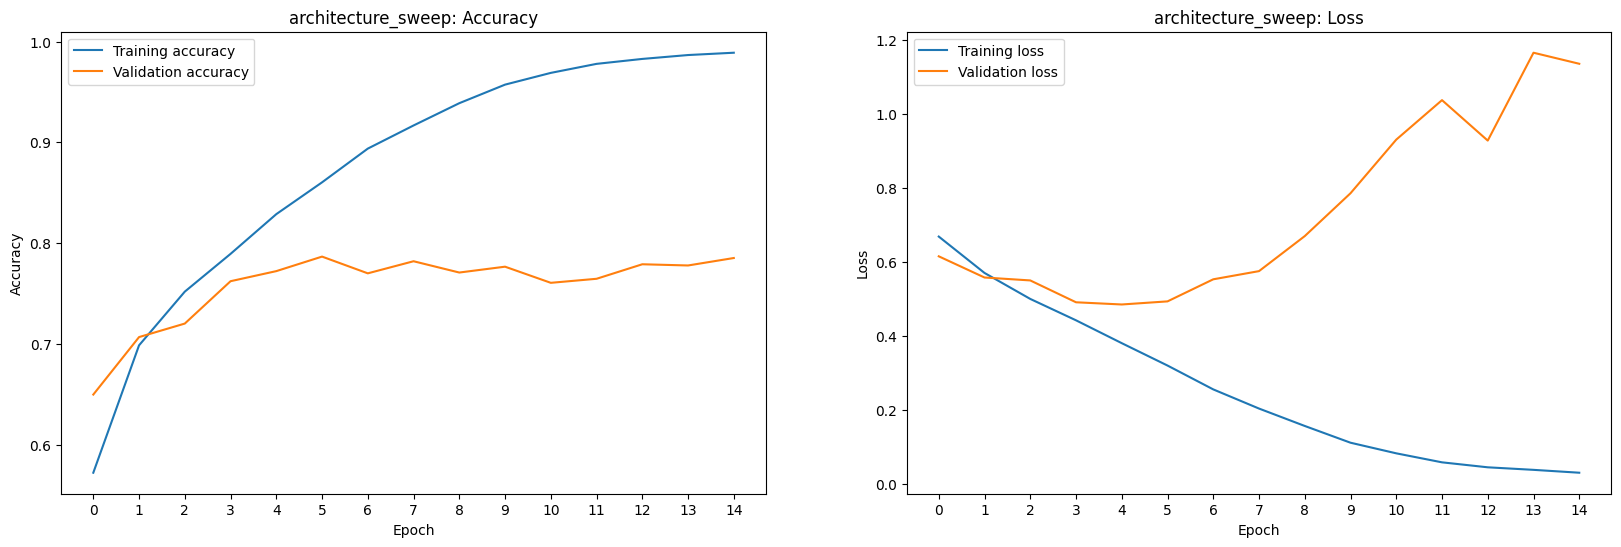

Current best validation accuracy:  0.8626351356506348
Testing architecture config (trial 11): [{'type': 'Conv2D', 'filters': 16, 'kernel_size': (3, 3)}, {'type': 'MaxPooling2D', 'pool_size': (2, 2)}, {'type': 'Dropout', 'rate': 0.4995111029764059}, {'type': 'Conv2D', 'filters': 32, 'kernel_size': (5, 5)}, {'type': 'MaxPooling2D', 'pool_size': (2, 2)}, {'type': 'Dropout', 'rate': 0.3387450531298442}, {'type': 'Conv2D', 'filters': 16, 'kernel_size': (3, 3)}, {'type': 'MaxPooling2D', 'pool_size': (3, 3)}, {'type': 'Flatten'}, {'type': 'Dense', 'units': 128, 'activation': 'relu'}, {'type': 'Dense', 'units': 2, 'activation': 'softmax'}]
Building model: architecture_sweep...
Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 256, 256, 16)      448       
                                                                 
 max_pooling2d_20 (MaxPoolin  (None

C:\Users\nates\anaconda3\envs\tflow\lib\site-packages\PIL\TiffImagePlugin.py:864: UserWarning: Truncated File Read
  warnings.warn(str(msg))


625/625 [==============================] - 55s 86ms/step - loss: 0.6984 - acc: 0.5373 - val_loss: 0.6903 - val_acc: 0.5036
Epoch 2/15
625/625 [==============================] - 53s 83ms/step - loss: 0.6309 - acc: 0.6334 - val_loss: 0.6193 - val_acc: 0.6712
Epoch 3/15
625/625 [==============================] - 54s 86ms/step - loss: 0.5616 - acc: 0.7058 - val_loss: 0.5649 - val_acc: 0.7215
Epoch 4/15
625/625 [==============================] - 56s 90ms/step - loss: 0.5293 - acc: 0.7325 - val_loss: 0.5407 - val_acc: 0.7441
Epoch 5/15
625/625 [==============================] - 55s 88ms/step - loss: 0.4971 - acc: 0.7551 - val_loss: 0.5188 - val_acc: 0.7579
Epoch 6/15
625/625 [==============================] - 57s 91ms/step - loss: 0.4684 - acc: 0.7774 - val_loss: 0.5048 - val_acc: 0.7603
Epoch 7/15
625/625 [==============================] - 53s 84ms/step - loss: 0.4444 - acc: 0.7881 - val_loss: 0.4804 - val_acc: 0.7757
Epoch 8/15
625/625 [==============================] - 58s 92ms/step - los

KeyboardInterrupt: 

In [10]:
other_params = {
    "batch_size": 32,
    "activation_function": "relu",
    "epochs": 15,
    "loss_function": "binary_crossentropy"
}

# best config was found by running the sweep algorithm below
best_config = sweep_architecture_params(BASE_IMAGE_DIR, 5, other_params=other_params)



### Grid search for params based on fixed architecture

In [13]:
# of the candidate architectures, the second one in the list is best
# now, run a grid search to find other params

# UNCOMMENT AFTER RUNNING
#best_config = candidate_architecture_configs[1]

## REMOVE AFTER RUNNING 
# best_config = [
#     {'type': 'Conv2D', 'filters': 24, 'kernel_size': (5, 5)}, 
#     {'type': 'MaxPooling2D', 'pool_size': (2, 2)},
#     {'type': 'Conv2D', 'filters': 48, 'kernel_size': (5, 5)}, 
#     {'type': 'MaxPooling2D', 'pool_size': (2, 2)},
#     {'type': 'Conv2D', 'filters': 96, 'kernel_size': (5, 5)},
#     {'type': 'MaxPooling2D', 'pool_size': (2, 2)}, 
#     {'type': 'Flatten'},
#     {'type': 'Dropout', 'rate': 0.9}, 
#     {'type': 'Dense', 'units': 64, 'activation': 'relu'}, 
#     {'type': 'Dense', 'units': 2, 'activation': 'sigmoid'}
# ]

best_config = [
    {'type': 'Conv2D', 'filters': 16, 'kernel_size': (3, 3)}, 
    {'type': 'MaxPooling2D', 'pool_size': (2, 2)}, 
    {'type': 'Dropout', 'rate': 0.30703886128813807}, 
    {'type': 'Flatten'}, 
    {'type': 'Dense', 'units': 256, 'activation': 'tanh'},
    {'type': 'Dense', 'units': 2, 'activation': 'softmax'}
]


activation_functions = ['relu', 'sigmoid']
batch_sizes = [16, 32, 64]
loss_functions = ['binary_crossentropy']
epochs_list = [15]
dropout_rates = [0.5, 0.9]

# call the grid search function to evaluate the best model combination
results = grid_search(
    BASE_IMAGE_DIR,
    best_config,
    activation_functions,
    batch_sizes,
    loss_functions, 
    epochs_list,
    dropout_rates)



Training model: model_relu_16_binary_crossentropy_15_0.5
Building model: model_relu_16_binary_crossentropy_15_0.5...
Using dropout rate: 0.5
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 256, 256, 16)      448       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 128, 128, 16)     0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 128, 128, 16)      0         
                                                                 
 flatten_1 (Flatten)         (None, 262144)            0         
                                                                 
 dense_2 (Dense)             (None, 256)               67109120  
                                             

C:\Users\nates\anaconda3\envs\tflow\lib\site-packages\PIL\TiffImagePlugin.py:864: UserWarning: Truncated File Read
  warnings.warn(str(msg))


1249/1249 [==============================] - 42s 33ms/step - loss: 0.8655 - acc: 0.5108 - val_loss: 0.6978 - val_acc: 0.5002
Epoch 2/15
1249/1249 [==============================] - 40s 32ms/step - loss: 0.5978 - acc: 0.6665 - val_loss: 0.5255 - val_acc: 0.7389
Epoch 3/15
1249/1249 [==============================] - 40s 32ms/step - loss: 0.4735 - acc: 0.7739 - val_loss: 0.5210 - val_acc: 0.7385
Epoch 4/15
1249/1249 [==============================] - 47s 37ms/step - loss: 0.3592 - acc: 0.8405 - val_loss: 0.5375 - val_acc: 0.7423
Epoch 5/15
1249/1249 [==============================] - 38s 30ms/step - loss: 0.2445 - acc: 0.9026 - val_loss: 0.5762 - val_acc: 0.7441
Epoch 6/15
1249/1249 [==============================] - 42s 34ms/step - loss: 0.1511 - acc: 0.9444 - val_loss: 0.6289 - val_acc: 0.7459
Epoch 7/15
1249/1249 [==============================] - 40s 32ms/step - loss: 0.0940 - acc: 0.9691 - val_loss: 0.7459 - val_acc: 0.7353
Epoch 8/15
1249/1249 [==============================] - 40s

INFO:tensorflow:Assets written to: C:\dev\programming_2023\cnn_project\kagglecatsanddogs_5340\PetImages/models/model_relu_16_binary_crossentropy_15_0.5\assets


INFO:tensorflow:Assets written to: C:\dev\programming_2023\cnn_project\kagglecatsanddogs_5340\PetImages/models/model_relu_16_binary_crossentropy_15_0.5\assets


Training model: model_relu_16_binary_crossentropy_15_0.9
Building model: model_relu_16_binary_crossentropy_15_0.9...
Using dropout rate: 0.9
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 256, 256, 16)      448       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 128, 128, 16)     0         
 2D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 128, 128, 16)      0         
                                                                 
 flatten_2 (Flatten)         (None, 262144)            0         
                                                                 
 dense_4 (Dense)             (None, 256)               67109120  
                                             

C:\Users\nates\anaconda3\envs\tflow\lib\site-packages\PIL\TiffImagePlugin.py:864: UserWarning: Truncated File Read
  warnings.warn(str(msg))


1249/1249 [==============================] - 38s 30ms/step - loss: 0.7065 - acc: 0.5724 - val_loss: 0.6265 - val_acc: 0.6346
Epoch 2/15
1249/1249 [==============================] - 39s 32ms/step - loss: 0.5988 - acc: 0.6650 - val_loss: 0.5764 - val_acc: 0.6866
Epoch 3/15
1249/1249 [==============================] - 37s 30ms/step - loss: 0.5583 - acc: 0.7036 - val_loss: 0.5374 - val_acc: 0.7261
Epoch 4/15
1249/1249 [==============================] - 36s 28ms/step - loss: 0.5231 - acc: 0.7331 - val_loss: 0.5285 - val_acc: 0.7343
Epoch 5/15
1249/1249 [==============================] - 40s 32ms/step - loss: 0.4960 - acc: 0.7586 - val_loss: 0.5117 - val_acc: 0.7439
Epoch 6/15
1249/1249 [==============================] - 40s 32ms/step - loss: 0.4648 - acc: 0.7742 - val_loss: 0.5140 - val_acc: 0.7451
Epoch 7/15
1249/1249 [==============================] - 40s 32ms/step - loss: 0.4418 - acc: 0.7870 - val_loss: 0.4981 - val_acc: 0.7589
Epoch 8/15
1249/1249 [==============================] - 41s

INFO:tensorflow:Assets written to: C:\dev\programming_2023\cnn_project\kagglecatsanddogs_5340\PetImages/models/model_relu_16_binary_crossentropy_15_0.9\assets


INFO:tensorflow:Assets written to: C:\dev\programming_2023\cnn_project\kagglecatsanddogs_5340\PetImages/models/model_relu_16_binary_crossentropy_15_0.9\assets


Training model: model_relu_32_binary_crossentropy_15_0.5
Building model: model_relu_32_binary_crossentropy_15_0.5...
Using dropout rate: 0.5
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 256, 256, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 128, 128, 16)     0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 128, 128, 16)      0         
                                                                 
 flatten_3 (Flatten)         (None, 262144)            0         
                                                                 
 dense_6 (Dense)             (None, 256)               67109120  
                                             

C:\Users\nates\anaconda3\envs\tflow\lib\site-packages\PIL\TiffImagePlugin.py:864: UserWarning: Truncated File Read
  warnings.warn(str(msg))


625/625 [==============================] - 26s 41ms/step - loss: 1.0354 - acc: 0.5011 - val_loss: 0.6943 - val_acc: 0.5000
Epoch 2/15
625/625 [==============================] - 27s 44ms/step - loss: 0.6940 - acc: 0.5117 - val_loss: 0.6907 - val_acc: 0.5000
Epoch 3/15
625/625 [==============================] - 28s 44ms/step - loss: 0.6331 - acc: 0.6368 - val_loss: 0.5607 - val_acc: 0.7127
Epoch 4/15
625/625 [==============================] - 30s 47ms/step - loss: 0.5134 - acc: 0.7484 - val_loss: 0.5121 - val_acc: 0.7425
Epoch 5/15
625/625 [==============================] - 25s 40ms/step - loss: 0.4115 - acc: 0.8116 - val_loss: 0.5384 - val_acc: 0.7331
Epoch 6/15
625/625 [==============================] - 25s 40ms/step - loss: 0.3126 - acc: 0.8669 - val_loss: 0.5229 - val_acc: 0.7619
Epoch 7/15
625/625 [==============================] - 29s 46ms/step - loss: 0.2138 - acc: 0.9195 - val_loss: 0.5645 - val_acc: 0.7573
Epoch 8/15
625/625 [==============================] - 29s 46ms/step - los

INFO:tensorflow:Assets written to: C:\dev\programming_2023\cnn_project\kagglecatsanddogs_5340\PetImages/models/model_relu_32_binary_crossentropy_15_0.5\assets


INFO:tensorflow:Assets written to: C:\dev\programming_2023\cnn_project\kagglecatsanddogs_5340\PetImages/models/model_relu_32_binary_crossentropy_15_0.5\assets


Training model: model_relu_32_binary_crossentropy_15_0.9
Building model: model_relu_32_binary_crossentropy_15_0.9...
Using dropout rate: 0.9
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 256, 256, 16)      448       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 128, 128, 16)     0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 128, 128, 16)      0         
                                                                 
 flatten_4 (Flatten)         (None, 262144)            0         
                                                                 
 dense_8 (Dense)             (None, 256)               67109120  
                                             

C:\Users\nates\anaconda3\envs\tflow\lib\site-packages\PIL\TiffImagePlugin.py:864: UserWarning: Truncated File Read
  warnings.warn(str(msg))


625/625 [==============================] - 28s 43ms/step - loss: 1.0173 - acc: 0.4955 - val_loss: 0.6931 - val_acc: 0.5082
Epoch 2/15
625/625 [==============================] - 28s 44ms/step - loss: 0.6699 - acc: 0.5724 - val_loss: 0.6191 - val_acc: 0.6530
Epoch 3/15
625/625 [==============================] - 25s 40ms/step - loss: 0.5966 - acc: 0.6755 - val_loss: 0.5587 - val_acc: 0.7187
Epoch 4/15
625/625 [==============================] - 25s 40ms/step - loss: 0.5478 - acc: 0.7165 - val_loss: 0.5388 - val_acc: 0.7285
Epoch 5/15
625/625 [==============================] - 28s 44ms/step - loss: 0.5130 - acc: 0.7438 - val_loss: 0.5134 - val_acc: 0.7437
Epoch 6/15
625/625 [==============================] - 25s 40ms/step - loss: 0.4886 - acc: 0.7590 - val_loss: 0.5095 - val_acc: 0.7401
Epoch 7/15
625/625 [==============================] - 27s 43ms/step - loss: 0.4637 - acc: 0.7753 - val_loss: 0.5055 - val_acc: 0.7477
Epoch 8/15
625/625 [==============================] - 26s 42ms/step - los

INFO:tensorflow:Assets written to: C:\dev\programming_2023\cnn_project\kagglecatsanddogs_5340\PetImages/models/model_relu_32_binary_crossentropy_15_0.9\assets


INFO:tensorflow:Assets written to: C:\dev\programming_2023\cnn_project\kagglecatsanddogs_5340\PetImages/models/model_relu_32_binary_crossentropy_15_0.9\assets


Training model: model_relu_64_binary_crossentropy_15_0.5
Building model: model_relu_64_binary_crossentropy_15_0.5...
Using dropout rate: 0.5
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 256, 256, 16)      448       
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 128, 128, 16)     0         
 2D)                                                             
                                                                 
 dropout_5 (Dropout)         (None, 128, 128, 16)      0         
                                                                 
 flatten_5 (Flatten)         (None, 262144)            0         
                                                                 
 dense_10 (Dense)            (None, 256)               67109120  
                                             

C:\Users\nates\anaconda3\envs\tflow\lib\site-packages\PIL\TiffImagePlugin.py:864: UserWarning: Truncated File Read
  warnings.warn(str(msg))


313/313 [==============================] - 29s 88ms/step - loss: 1.4900 - acc: 0.4969 - val_loss: 0.6936 - val_acc: 0.5000
Epoch 2/15
313/313 [==============================] - 28s 88ms/step - loss: 0.6943 - acc: 0.4936 - val_loss: 0.6951 - val_acc: 0.5000
Epoch 3/15
313/313 [==============================] - 29s 92ms/step - loss: 0.6940 - acc: 0.5047 - val_loss: 0.6950 - val_acc: 0.5000
Epoch 4/15
313/313 [==============================] - 23s 72ms/step - loss: 0.6941 - acc: 0.4986 - val_loss: 0.6943 - val_acc: 0.5000
Epoch 5/15
313/313 [==============================] - 26s 81ms/step - loss: 0.6940 - acc: 0.5015 - val_loss: 0.6934 - val_acc: 0.5000
Epoch 6/15
313/313 [==============================] - 29s 92ms/step - loss: 0.6947 - acc: 0.4969 - val_loss: 0.6947 - val_acc: 0.5000
Epoch 7/15
313/313 [==============================] - 30s 93ms/step - loss: 0.6943 - acc: 0.4972 - val_loss: 0.6937 - val_acc: 0.5000
Epoch 8/15
313/313 [==============================] - 26s 82ms/step - los

INFO:tensorflow:Assets written to: C:\dev\programming_2023\cnn_project\kagglecatsanddogs_5340\PetImages/models/model_relu_64_binary_crossentropy_15_0.5\assets


INFO:tensorflow:Assets written to: C:\dev\programming_2023\cnn_project\kagglecatsanddogs_5340\PetImages/models/model_relu_64_binary_crossentropy_15_0.5\assets


Training model: model_relu_64_binary_crossentropy_15_0.9
Building model: model_relu_64_binary_crossentropy_15_0.9...
Using dropout rate: 0.9
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 256, 256, 16)      448       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 128, 128, 16)     0         
 2D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 128, 128, 16)      0         
                                                                 
 flatten_6 (Flatten)         (None, 262144)            0         
                                                                 
 dense_12 (Dense)            (None, 256)               67109120  
                                             

C:\Users\nates\anaconda3\envs\tflow\lib\site-packages\PIL\TiffImagePlugin.py:864: UserWarning: Truncated File Read
  warnings.warn(str(msg))


313/313 [==============================] - 27s 83ms/step - loss: 0.8543 - acc: 0.5115 - val_loss: 0.6924 - val_acc: 0.5000
Epoch 2/15
313/313 [==============================] - 23s 72ms/step - loss: 0.6876 - acc: 0.5473 - val_loss: 0.6718 - val_acc: 0.6217
Epoch 3/15
313/313 [==============================] - 27s 85ms/step - loss: 0.6319 - acc: 0.6467 - val_loss: 0.5791 - val_acc: 0.7002
Epoch 4/15
313/313 [==============================] - 23s 71ms/step - loss: 0.5675 - acc: 0.7028 - val_loss: 0.5397 - val_acc: 0.7293
Epoch 5/15
313/313 [==============================] - 23s 72ms/step - loss: 0.5282 - acc: 0.7313 - val_loss: 0.5208 - val_acc: 0.7341
Epoch 6/15
313/313 [==============================] - 26s 82ms/step - loss: 0.4999 - acc: 0.7501 - val_loss: 0.5122 - val_acc: 0.7435
Epoch 7/15
313/313 [==============================] - 23s 72ms/step - loss: 0.4722 - acc: 0.7756 - val_loss: 0.5010 - val_acc: 0.7471
Epoch 8/15
313/313 [==============================] - 24s 76ms/step - los

INFO:tensorflow:Assets written to: C:\dev\programming_2023\cnn_project\kagglecatsanddogs_5340\PetImages/models/model_relu_64_binary_crossentropy_15_0.9\assets


INFO:tensorflow:Assets written to: C:\dev\programming_2023\cnn_project\kagglecatsanddogs_5340\PetImages/models/model_relu_64_binary_crossentropy_15_0.9\assets


Training model: model_sigmoid_16_binary_crossentropy_15_0.5
Building model: model_sigmoid_16_binary_crossentropy_15_0.5...
Using dropout rate: 0.5
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 256, 256, 16)      448       
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 128, 128, 16)     0         
 2D)                                                             
                                                                 
 dropout_7 (Dropout)         (None, 128, 128, 16)      0         
                                                                 
 flatten_7 (Flatten)         (None, 262144)            0         
                                                                 
 dense_14 (Dense)            (None, 256)               67109120  
                                       

C:\Users\nates\anaconda3\envs\tflow\lib\site-packages\PIL\TiffImagePlugin.py:864: UserWarning: Truncated File Read
  warnings.warn(str(msg))


1249/1249 [==============================] - 38s 30ms/step - loss: 0.8328 - acc: 0.5016 - val_loss: 0.6932 - val_acc: 0.5000
Epoch 2/15
 572/1249 [============>.................] - ETA: 18s - loss: 0.6970 - acc: 0.4984

KeyboardInterrupt: 

Model: model_relu_16_binary_crossentropy_15_0.5, best validation accuracy: 0.854425311088562


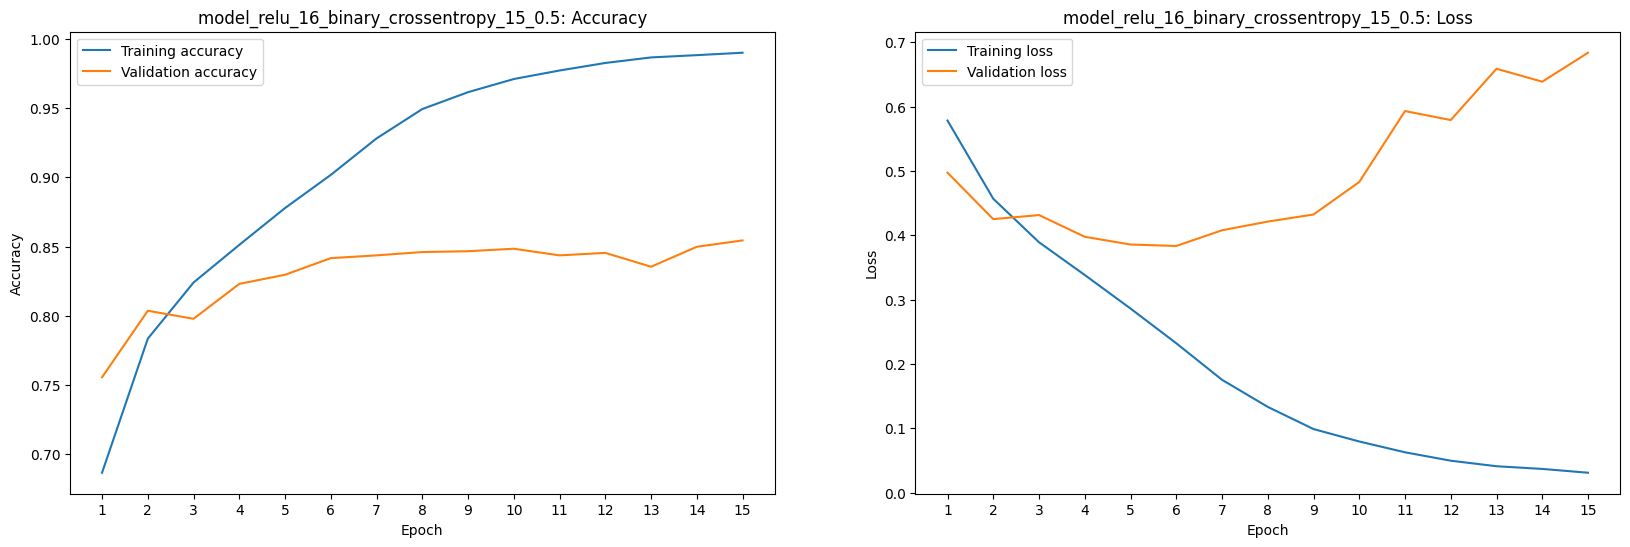

Model: model_relu_16_binary_crossentropy_15_0.9, best validation accuracy: 0.8712455034255981


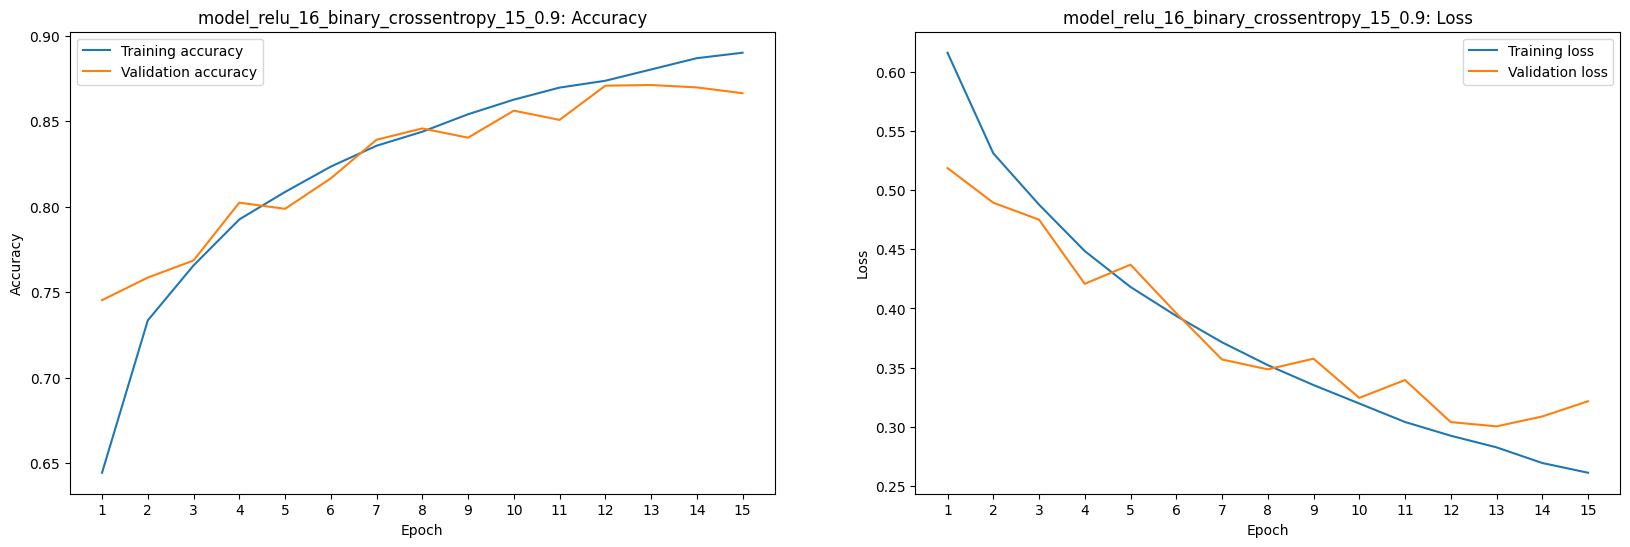

Model: model_relu_32_binary_crossentropy_15_0.5, best validation accuracy: 0.8492190837860107


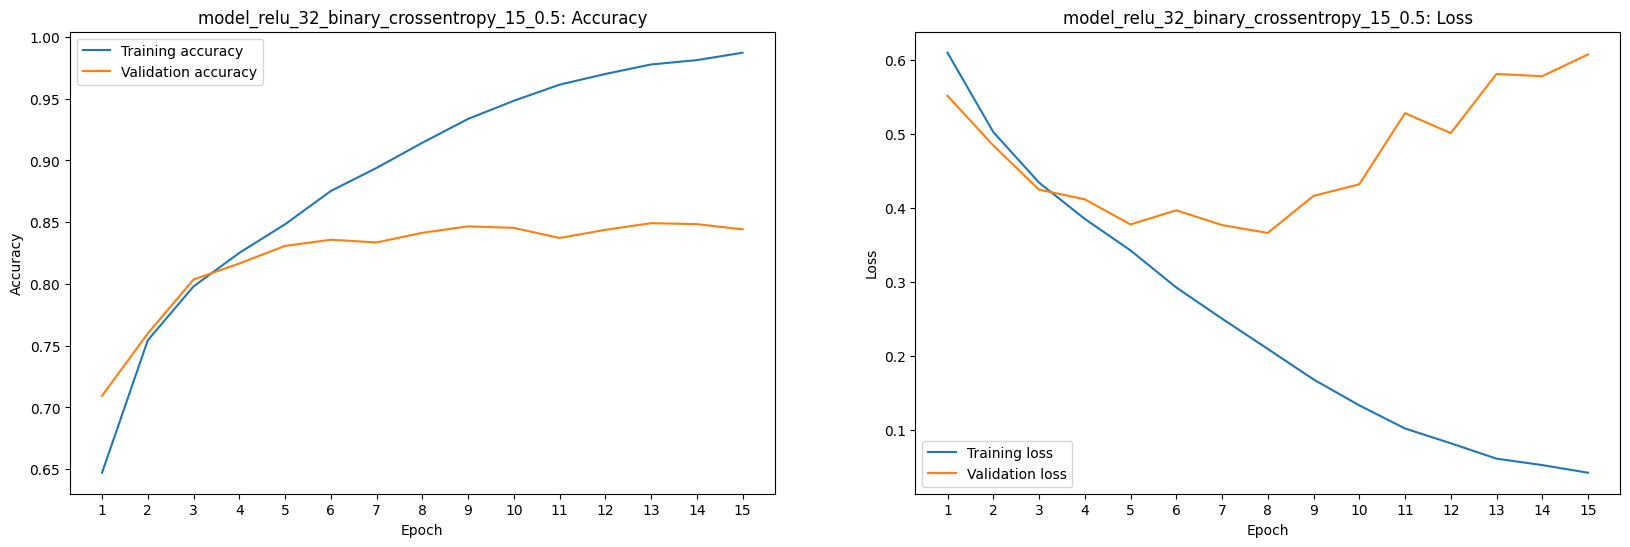

Model: model_relu_32_binary_crossentropy_15_0.9, best validation accuracy: 0.8690428733825684


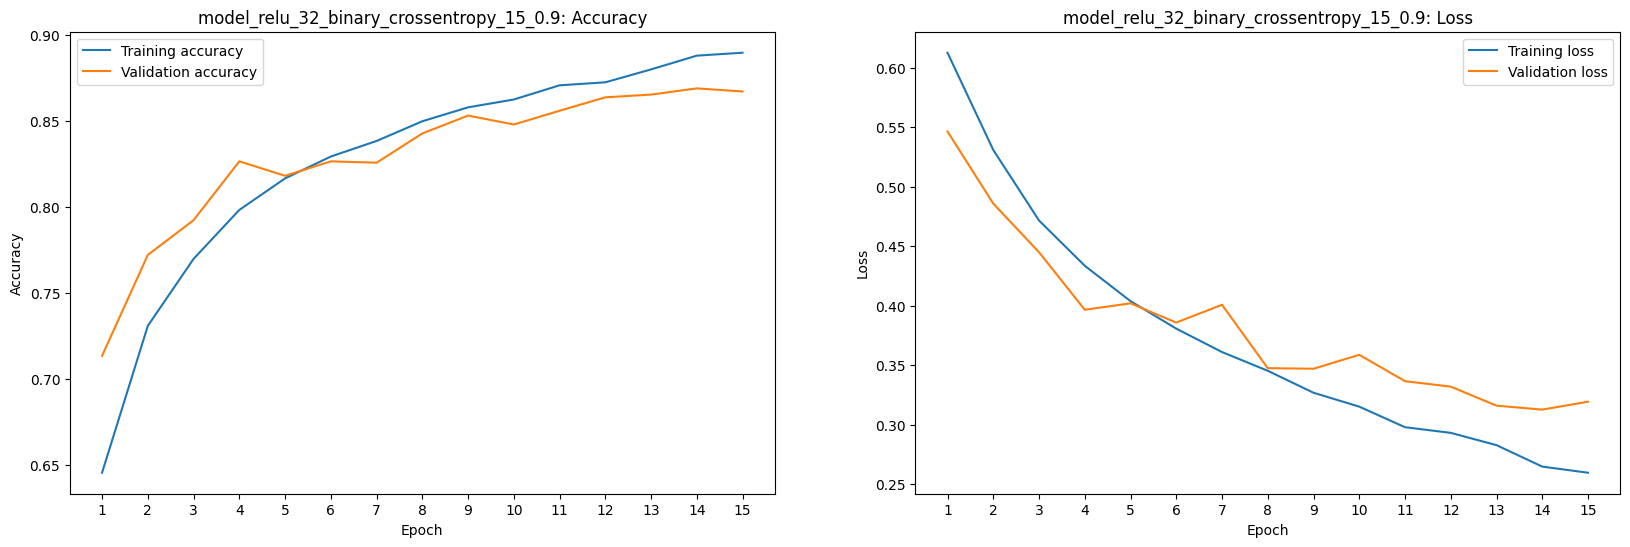

Model: model_relu_64_binary_crossentropy_15_0.5, best validation accuracy: 0.8512214422225952


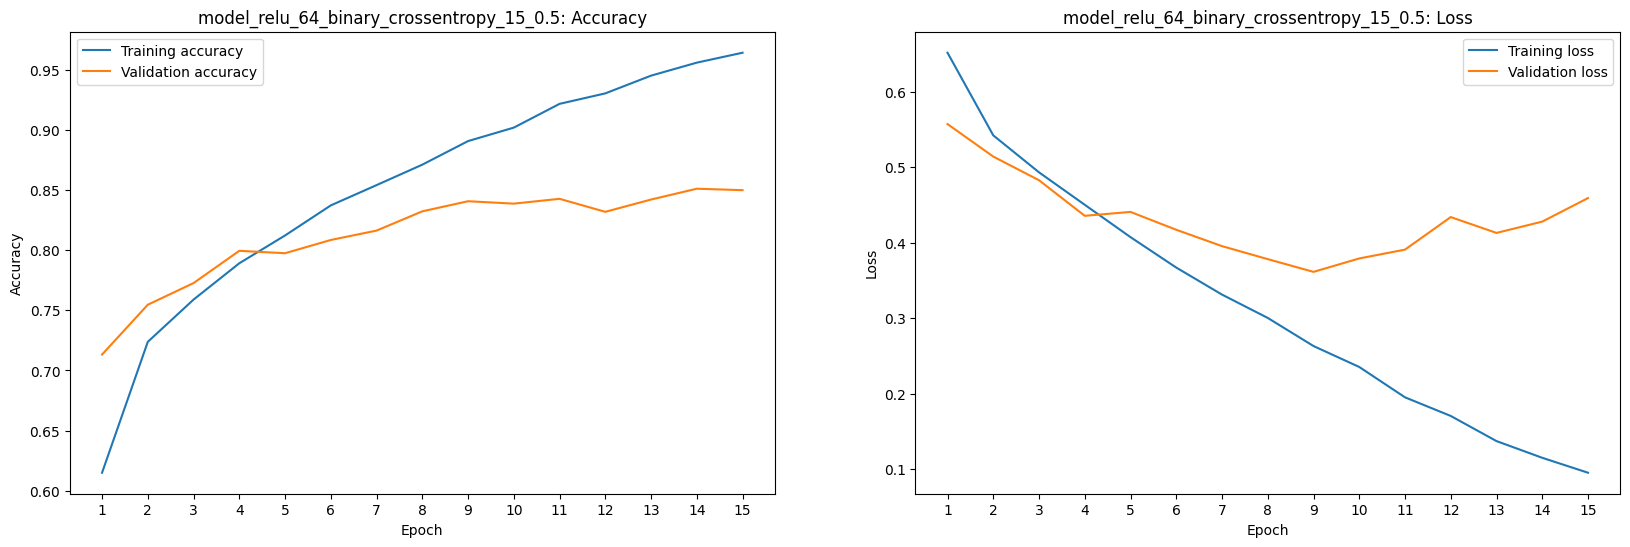

Model: model_relu_64_binary_crossentropy_15_0.9, best validation accuracy: 0.8736484050750732


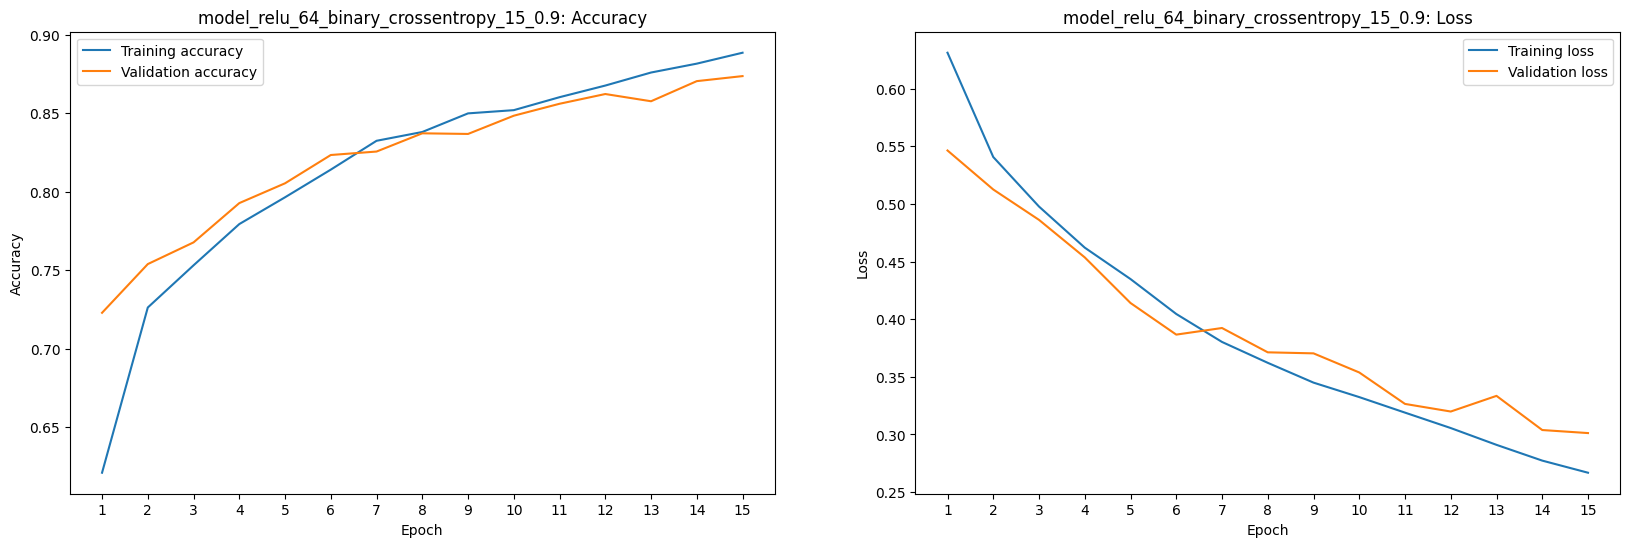

Model: model_sigmoid_16_binary_crossentropy_15_0.5, best validation accuracy: 0.5


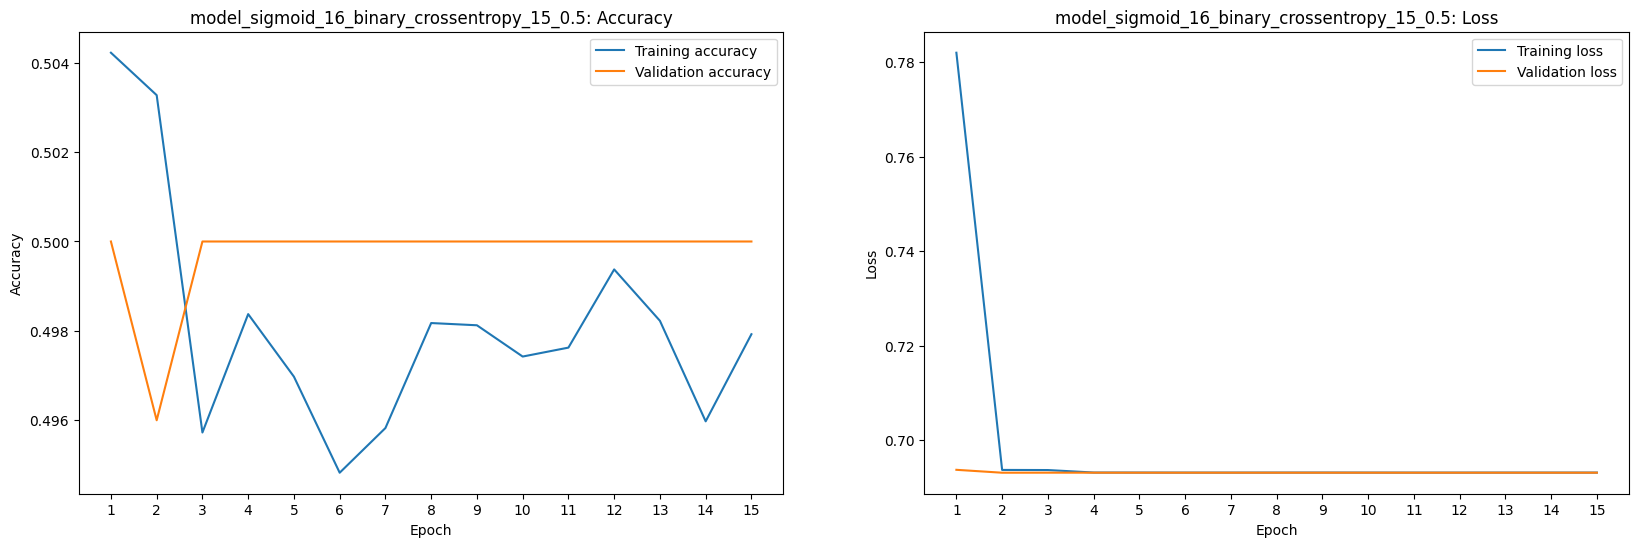

Model: model_sigmoid_16_binary_crossentropy_15_0.9, best validation accuracy: 0.5


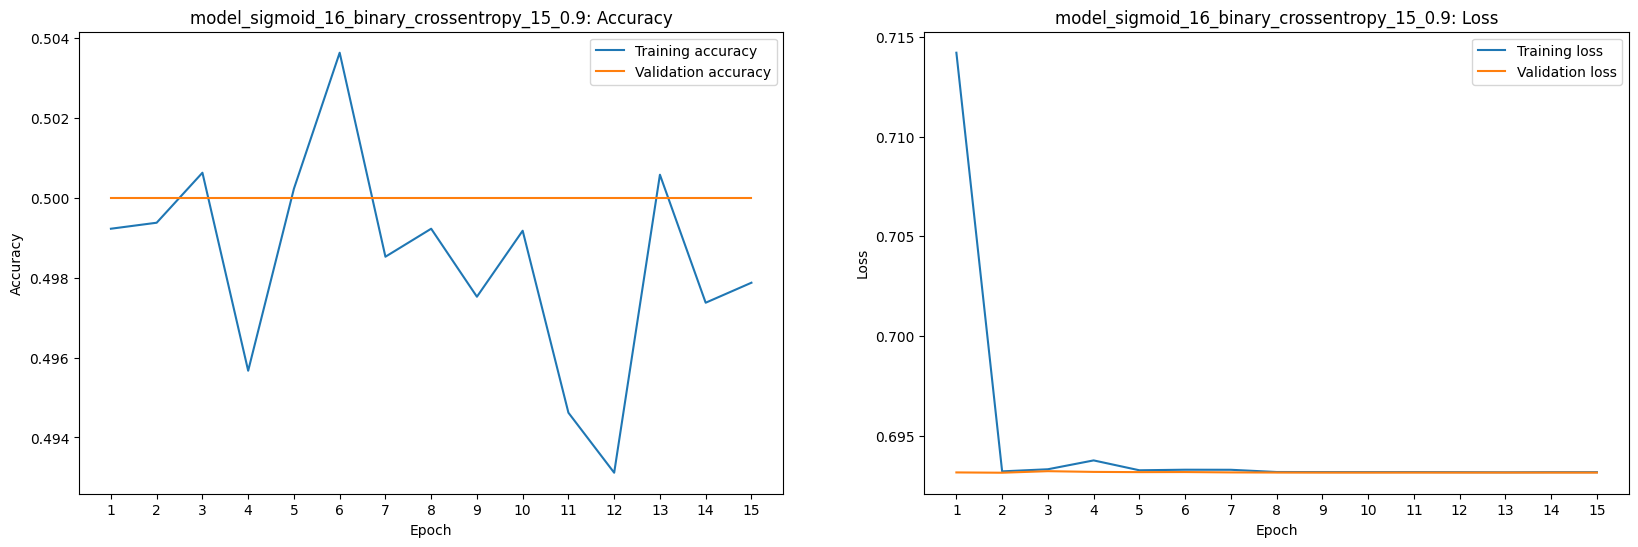

Model: model_sigmoid_32_binary_crossentropy_15_0.5, best validation accuracy: 0.5


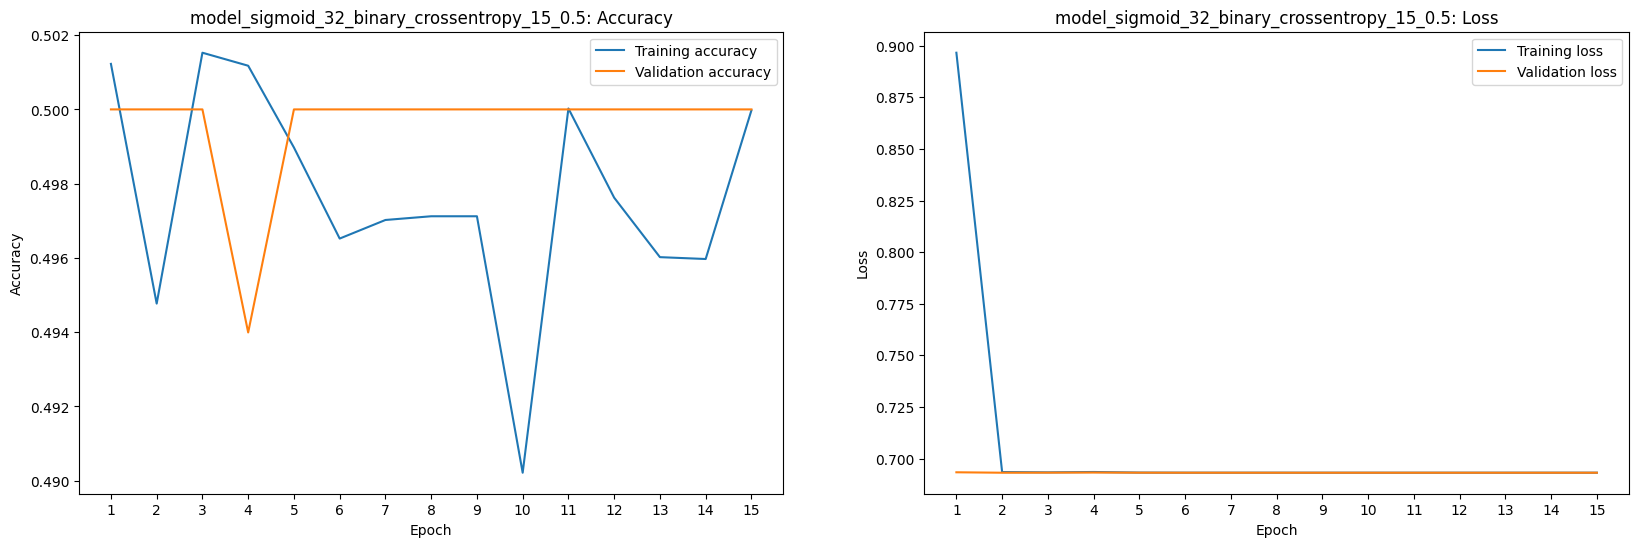

Model: model_sigmoid_32_binary_crossentropy_15_0.9, best validation accuracy: 0.6021225452423096


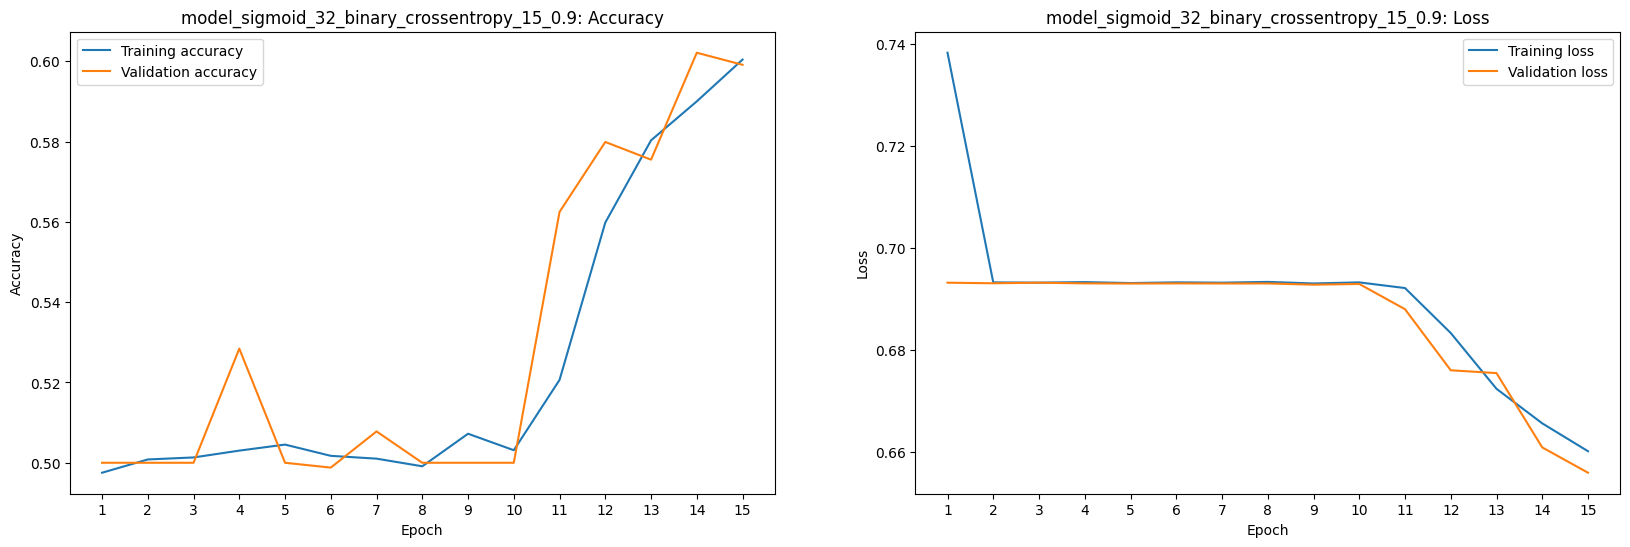

Model: model_sigmoid_64_binary_crossentropy_15_0.5, best validation accuracy: 0.5


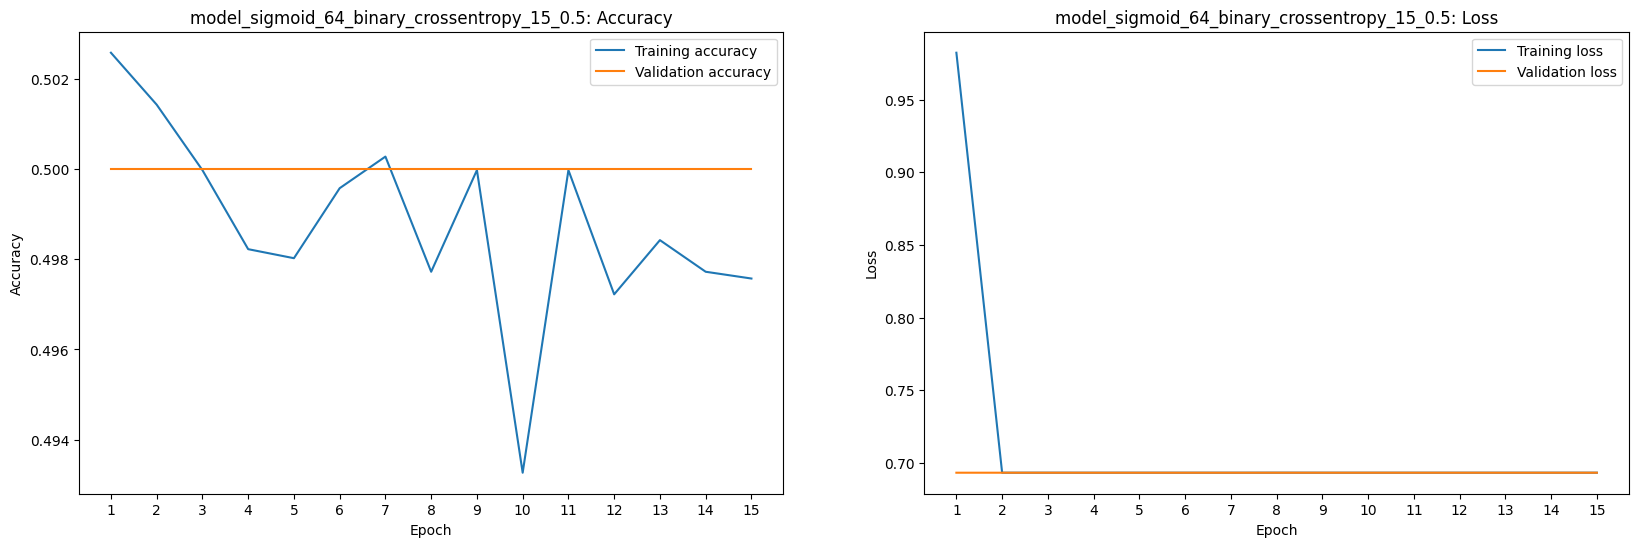

Model: model_sigmoid_64_binary_crossentropy_15_0.9, best validation accuracy: 0.5


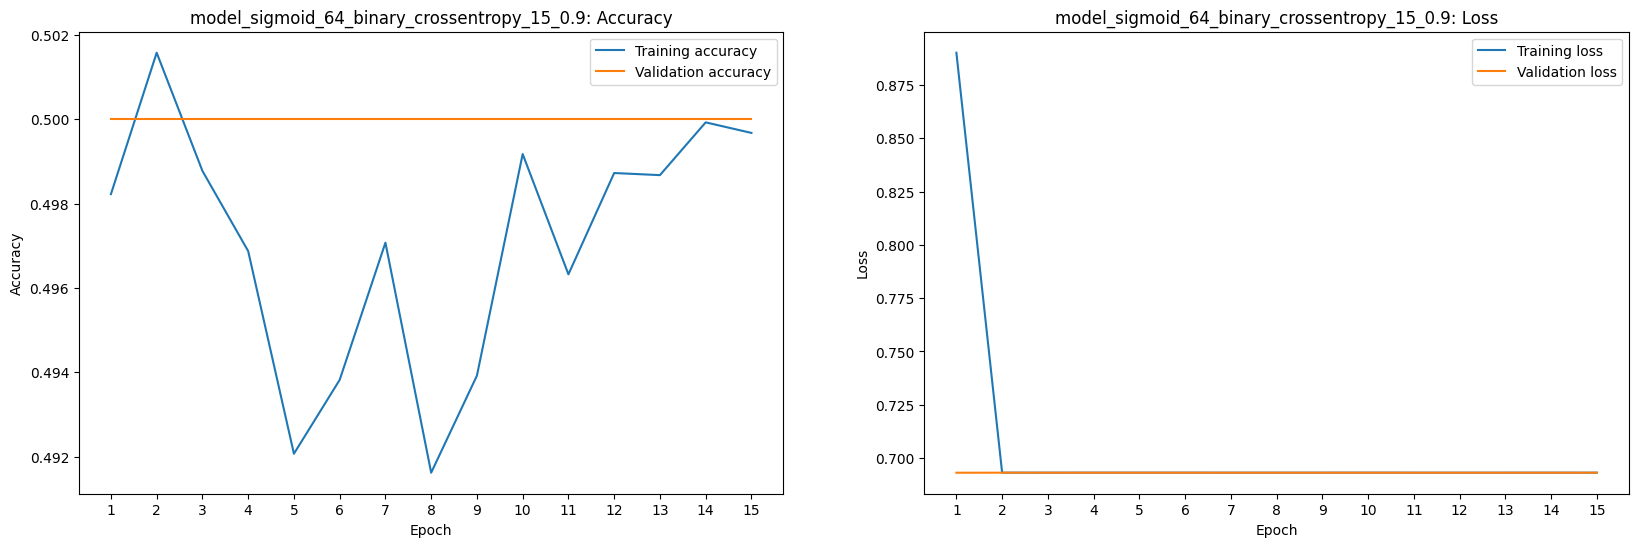

In [22]:
def plot_results_grid(results, save_dir='C:/dev/programming_2023/cnn_project/training_plots'):

    for i, result in enumerate(results):
        model_name = result['model_name']
        accuracy = result['accuracy']
        validation_accuracy = result['validation_accuracy']
        loss = result['loss']
        validation_loss = result['validation_loss']
        epochs = range(1, len(accuracy) + 1)
        
        print("Model: {}, best validation accuracy: {}".format(model_name, max(validation_accuracy)))

        fig, axes = plt.subplots(1, 2, figsize=(20, 6))

        # Plot accuracy
        axes[0].set_title(f"{model_name}: Accuracy")
        axes[0].plot(epochs, accuracy, label='Training accuracy')
        axes[0].plot(epochs, validation_accuracy, label='Validation accuracy')
        axes[0].set_xlabel("Epoch")
        axes[0].set_xticks(epochs)
        axes[0].set_ylabel("Accuracy")
        axes[0].legend()

        # Plot loss
        axes[1].set_title(f"{model_name}: Loss")
        axes[1].plot(epochs, loss, label='Training loss')
        axes[1].plot(epochs, validation_loss, label='Validation loss')
        axes[1].set_xlabel("Epoch")
        axes[1].set_xticks(epochs)
        axes[1].set_ylabel("Loss")
        axes[1].legend()

        # Save the figure
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)
        plt.show()
        fig.savefig(os.path.join(save_dir, f"{model_name}.png"))
        plt.close(fig)  # Close the figure to save memory

# Call the function with the results list
plot_results_grid(results)


# Appendix

In [ ]:
# LEGACY hardcodes candidate configs (pre random search)
candidate_architecture_configs = [
    # 2 convolutional layers, single dense layer
    [
        {"type": "Conv2D", "filters": 24, "kernel_size": (5, 5)},
        {"type": "MaxPooling2D", "pool_size": (2, 2)},
        {"type": "Conv2D", "filters": 48, "kernel_size": (5, 5)},
        {"type": "MaxPooling2D", "pool_size": (2, 2)},
        {"type": "Flatten"},
        {"type": "Dropout", "rate": 0.9},
        {"type": "Dense", "units": 2, "activation": "sigmoid"}
    ],
    # 3 convolutional layers, 2 dense layers (prev best)
    [
        {"type": "Conv2D", "filters": 24, "kernel_size": (5, 5)},
        {"type": "MaxPooling2D", "pool_size": (2, 2)},
        {"type": "Conv2D", "filters": 48, "kernel_size": (5, 5)},
        {"type": "MaxPooling2D", "pool_size": (2, 2)},
        {"type": "Conv2D", "filters": 128, "kernel_size": (5, 5)},
        {"type": "MaxPooling2D", "pool_size": (2, 2)},
        {"type": "Flatten"},
        {"type": "Dropout", "rate": 0.9},
        {"type": "Dense", "units": 64, "activation": "relu"},
        {"type": "Dense", "units": 2, "activation": "sigmoid"}
    ],
    # single conolutional layer, single dense layer
    [
        {"type": "Conv2D", "filters": 24, "kernel_size": (5, 5)},
        {"type": "MaxPooling2D", "pool_size": (2, 2)},
        {"type": "Flatten"},
        {"type": "Dropout", "rate": 0.9},
        {"type": "Dense", "units": 64, "activation": "relu"},
        {"type": "Dense", "units": 2, "activation": "sigmoid"}
    ],
    [
        # 3 convolutional layers, single dense layer
        {"type": "Conv2D", "filters": 24, "kernel_size": (5, 5)},
        {"type": "MaxPooling2D", "pool_size": (2, 2)},
        {"type": "Conv2D", "filters": 48, "kernel_size": (5, 5)},
        {"type": "MaxPooling2D", "pool_size": (2, 2)},
        {"type": "Conv2D", "filters": 96, "kernel_size": (5, 5)},
        {"type": "MaxPooling2D", "pool_size": (2, 2)},
        {"type": "Flatten"},
        {"type": "Dropout", "rate": 0.9},
        {"type": "Dense", "units": 2, "activation": "sigmoid"}
    ],
]


## Data Augmentation??

In [ ]:
TEST_CAT_DIR = r'C:\dev\programming_2023\cnn_project\test_cat'
        
first_images = os.listdir(TEST_CAT_DIR)[:20]
for image in first_images:
    test_img_path = "{}/{}".format(TEST_CAT_DIR, image)
    
    test_img =  cv2.cvtColor(cv2.imread(test_img_path), cv2.COLOR_BGR2RGB)
    
    # resize to  the net's inputs, normalize, and expant dims (for batch tensor)
    test_img = cv2.resize(test_img, (256, 256), interpolation=cv2.INTER_LINEAR)
    test_img = test_img.astype('float32') / 255.0
    test_img_expanded = np.expand_dims(test_img, axis=0)
    
    print(np.shape(test_img_expanded))
    break

    class_probabilities = model.predict(test_img_expanded)
    
    plt.imshow(test_img)
    plt.show()
    


In [ ]:
TEST_DOG_DIR = r'C:\dev\programming_2023\cnn_project\test_dog'
        
first_images = os.listdir(TEST_DOG_DIR)
for image in first_images:
    test_img_path = "{}/{}".format(TEST_DOG_DIR, image)
    
    test_img =  cv2.cvtColor(cv2.imread(test_img_path), cv2.COLOR_BGR2RGB)
    
    # resize to  the net's inputs, normalize, and expant dims (for batch tensor)
    test_img = cv2.resize(test_img, (256, 256), interpolation=cv2.INTER_LINEAR)
    test_img = test_img.astype('float32') / 255.0
    test_img_expanded = np.expand_dims(test_img, axis=0)
    
    print(np.shape(test_img_expanded))

    class_probabilities = model.predict(test_img_expanded)
    print("cat: {} dog: {}".format(class_probabilities[0][0], class_probabilities[0][1]))
    
    plt.imshow(test_img)
    plt.show()